# Create the understandability index

This is the main notebook where we create our understandability index. 

Steps:

1. Feature Extraction
   - Use Spacy and textdescriptives to extract linguistic features and readability metrics.
   - Calculate the percentage of standard CEFR vocabulary and common words.
2. Data Analysis
   - Examine how features are distributed across different text types.
3. Modeling
   - Use a Gaussian Mixture Model to identify outliers.
   - Create a Ridge Regression model using estimated difficulty levels as the target variable.
   - Choose a set of meaningful features that cover both syntactic and semantic aspects.
4. Index Creation
   - Train Ridge model on chosen features.
   - Scale predicted scores from model to a scale from -10 to 10.
   - Find sensible limits for CEFR levels:
     * Negative scores (-10 to 0): More complex texts (B2 to C2).
     * Positive scores (0 to 10): Simpler texts (B1 to A1).
5. Finalization
   - Refactor the index into a separate, reusable module that is pip installable.

**Imports**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.style.use("ggplot")

params = {
    "text.color": (0.25, 0.25, 0.25),
    "figure.figsize": [16, 9],
}

plt.rcParams.update(params)

# Get colors from default theme.
DEFAULT_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import seaborn as sns

import pandas as pd
from pandarallel import pandarallel
import numpy as np

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500
pandarallel.initialize(progress_bar=True)

from pickle import dump
from tqdm.notebook import tqdm
import warnings

warnings.simplefilter("ignore", category=UserWarning)

from utils_nlp import (
    extract_text_features,
    punctuate_lines,
)

import spacy

nlp = spacy.load("de_core_news_sm")

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


**Constants and functions**

In [2]:
INPUT_DIR = "_input/"

# Extract features

In [3]:
df = pd.read_parquet(f"{INPUT_DIR}zix_dataset.parq")
df = df.sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)
df

text_type                                               text
0             A2  - Die Verwaltung umfasst Planen, Koordinieren ...
1             B1  Verordnungen sind rechtliche Vorschriften, die...
2           RRBs  Auszug aus dem Protokoll des Regierungsrates d...
3     Admin News  Viele Unternehmen suchen nach qualifizierten A...
4             A2  Ein Gesetz ist eine Vorschrift für alle Mensch...
...          ...                                                ...
6475          B1  Der Nationalrat ist eine der beiden Kammern de...
6476          C1  Ein Besuch im Stadion ist immer ein besonderes...
6477          C1  Das Bundesgericht, auch als Bundesverfassungsg...
6478          C1  Das Schulfach Wirtschaft vermittelt umfassende...
6479       Legal  Es gebe keinen Grund, das Interesse der privat...

[6480 rows x 2 columns]

In [4]:
# Make sure all lines end with punctuation so that
# the sentence lengths can be calculated correctly.
df.text = df.text.apply(punctuate_lines)

We extract features with Spacy and [TextDescriptives](https://github.com/HLasse/TextDescriptives), which is a great package to extract a wide variety of text metrics. We experimented with all features that textdescriptices offers. For simplicity we show here only a small subset of features that we deem interesting for our index. Explore more [here](https://hlasse.github.io/TextDescriptives/usingthepackage.html#available-attributes) and feel free to experiment with other features too.

In [ ]:
features = df.text.parallel_apply(extract_text_features)
features = pd.concat(features.values).reset_index(drop=True)
df = pd.concat([df, features], axis=1)

# Explore data

In [6]:
relevant_cols = [
    ## Descriptive stats ------------------------------
    "proportion_unique_tokens",
    "token_length_mean",
    "token_length_std",
    "syllables_per_token_mean",
    "syllables_per_token_std",
    "sentence_length_mean",
    "sentence_length_std",
    ## Additional metrics -----------------------------
    "vocab_a1",
    "vocab_a2",
    "vocab_b1",
    "common_word_score",
    ## Readability ------------------------------------
    "flesch_kincaid_grade",
    # # We leave out Smog since it sometimes returns NaNs for short texts.
    # "smog",
    "gunning_fog",
    "automated_readability_index",
    "coleman_liau_index",
    "lix",
    "rix",
]

order = [
    "A1",
    "A2",
    "B1",
    "B2",
    "C1",
    "C2",
    "Admin News",
    "RRBs",
    "Legal",
]

From the mean feature values we can roughly intuit the difficulty of the various text types. No super clear picture emerges yet. The ranking depends very much on the features that we look at. 

In [7]:
df.groupby("text_type")[relevant_cols].mean().sort_values("rix").T[order].style.format(
    "{:.5f}"
)

From the plots we can see some features that seem expressive in regard to our assumed difficulty ranking, e.g. token and sentence lengths, the readability metrics as well as our common word score and the vocabularies.

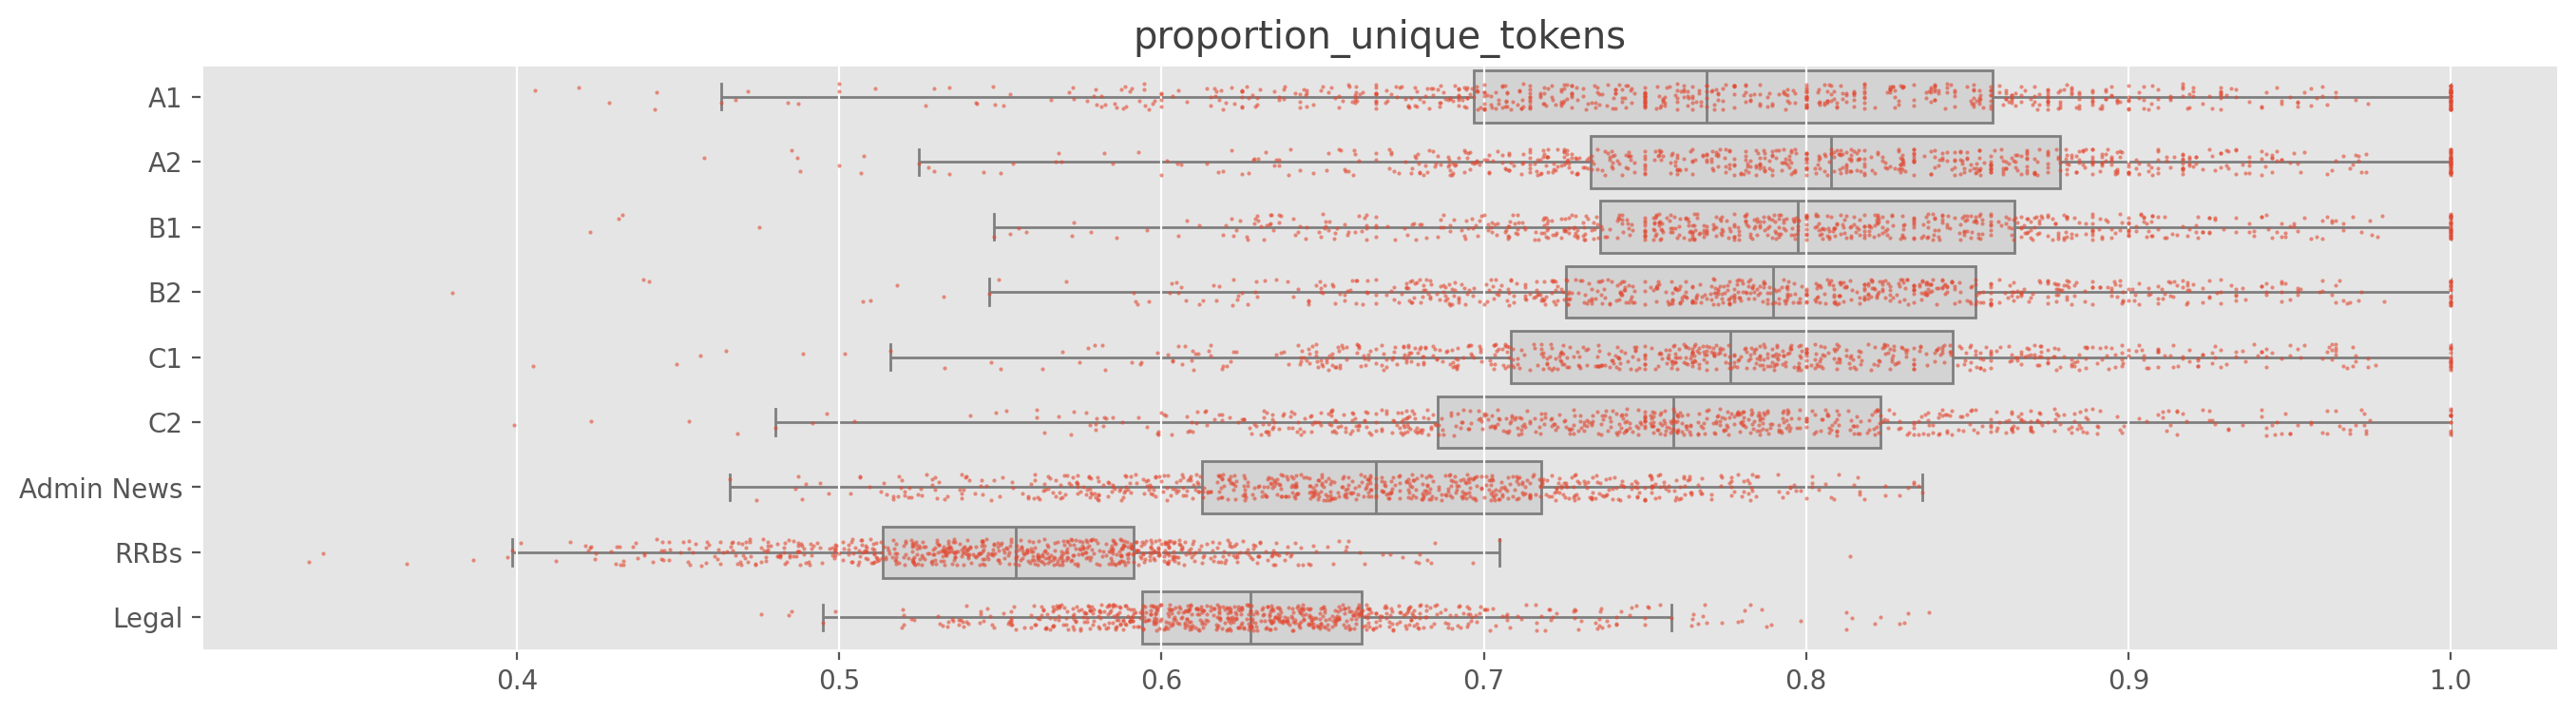

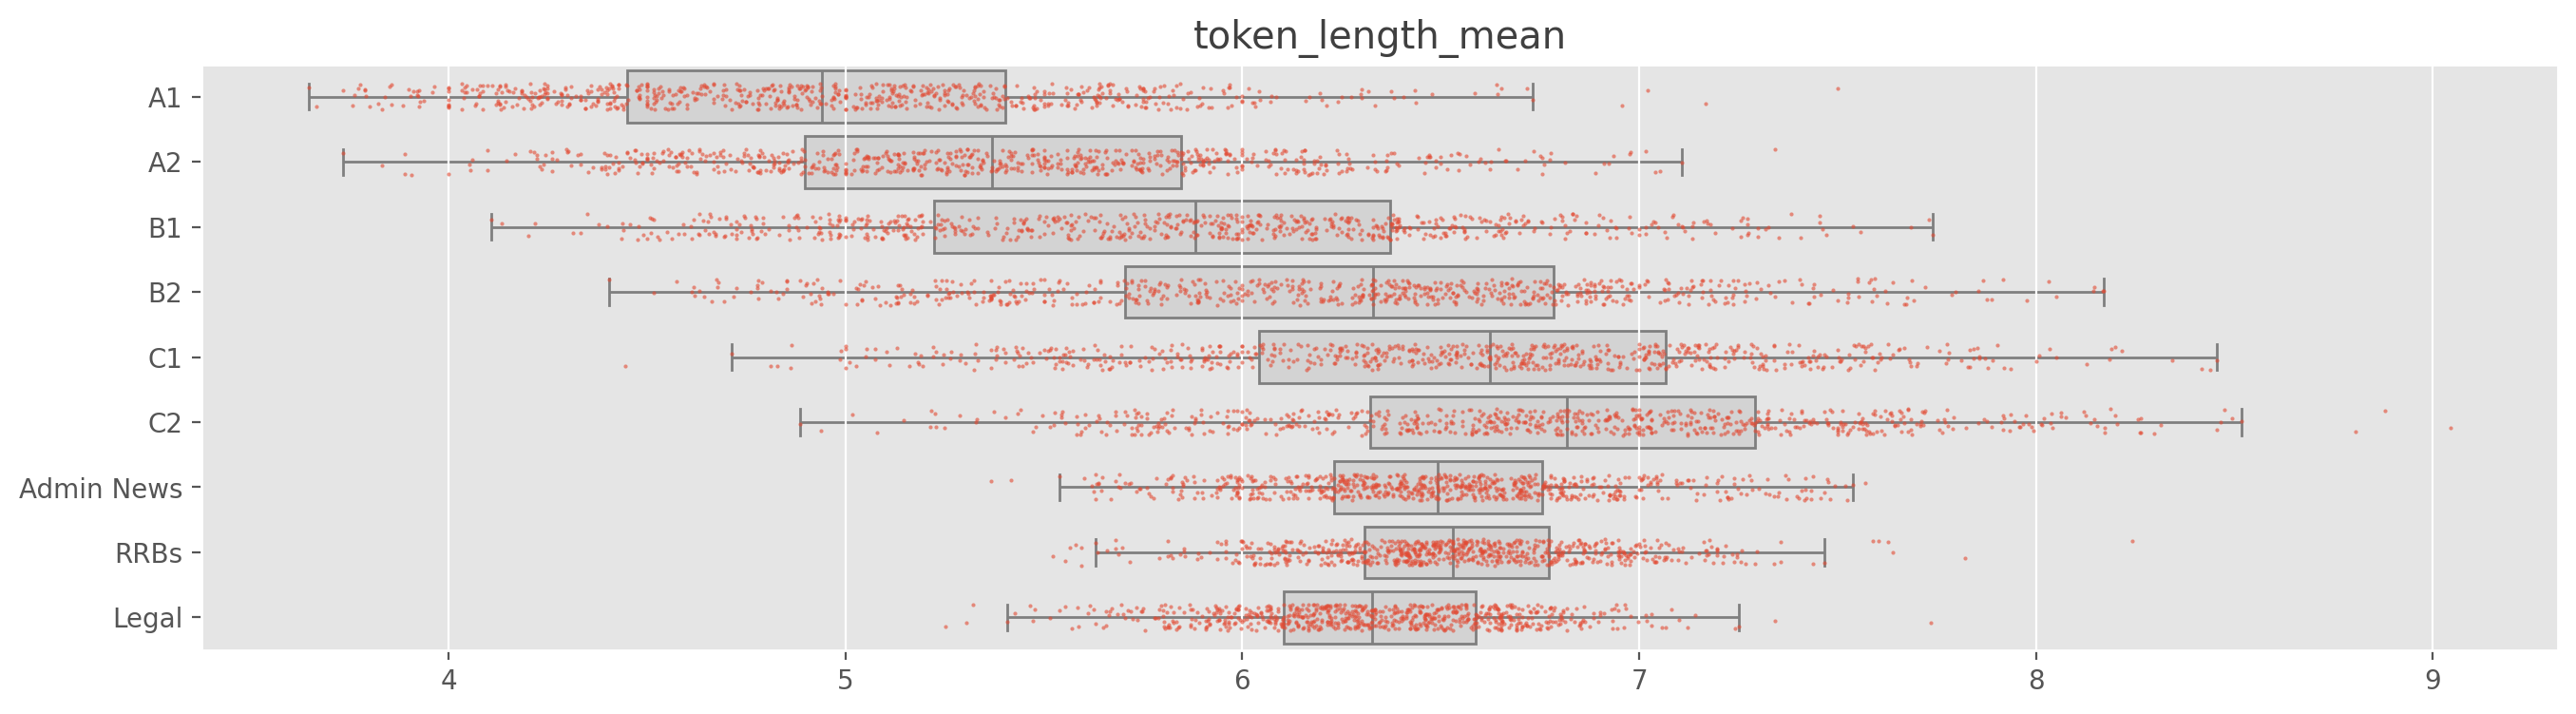

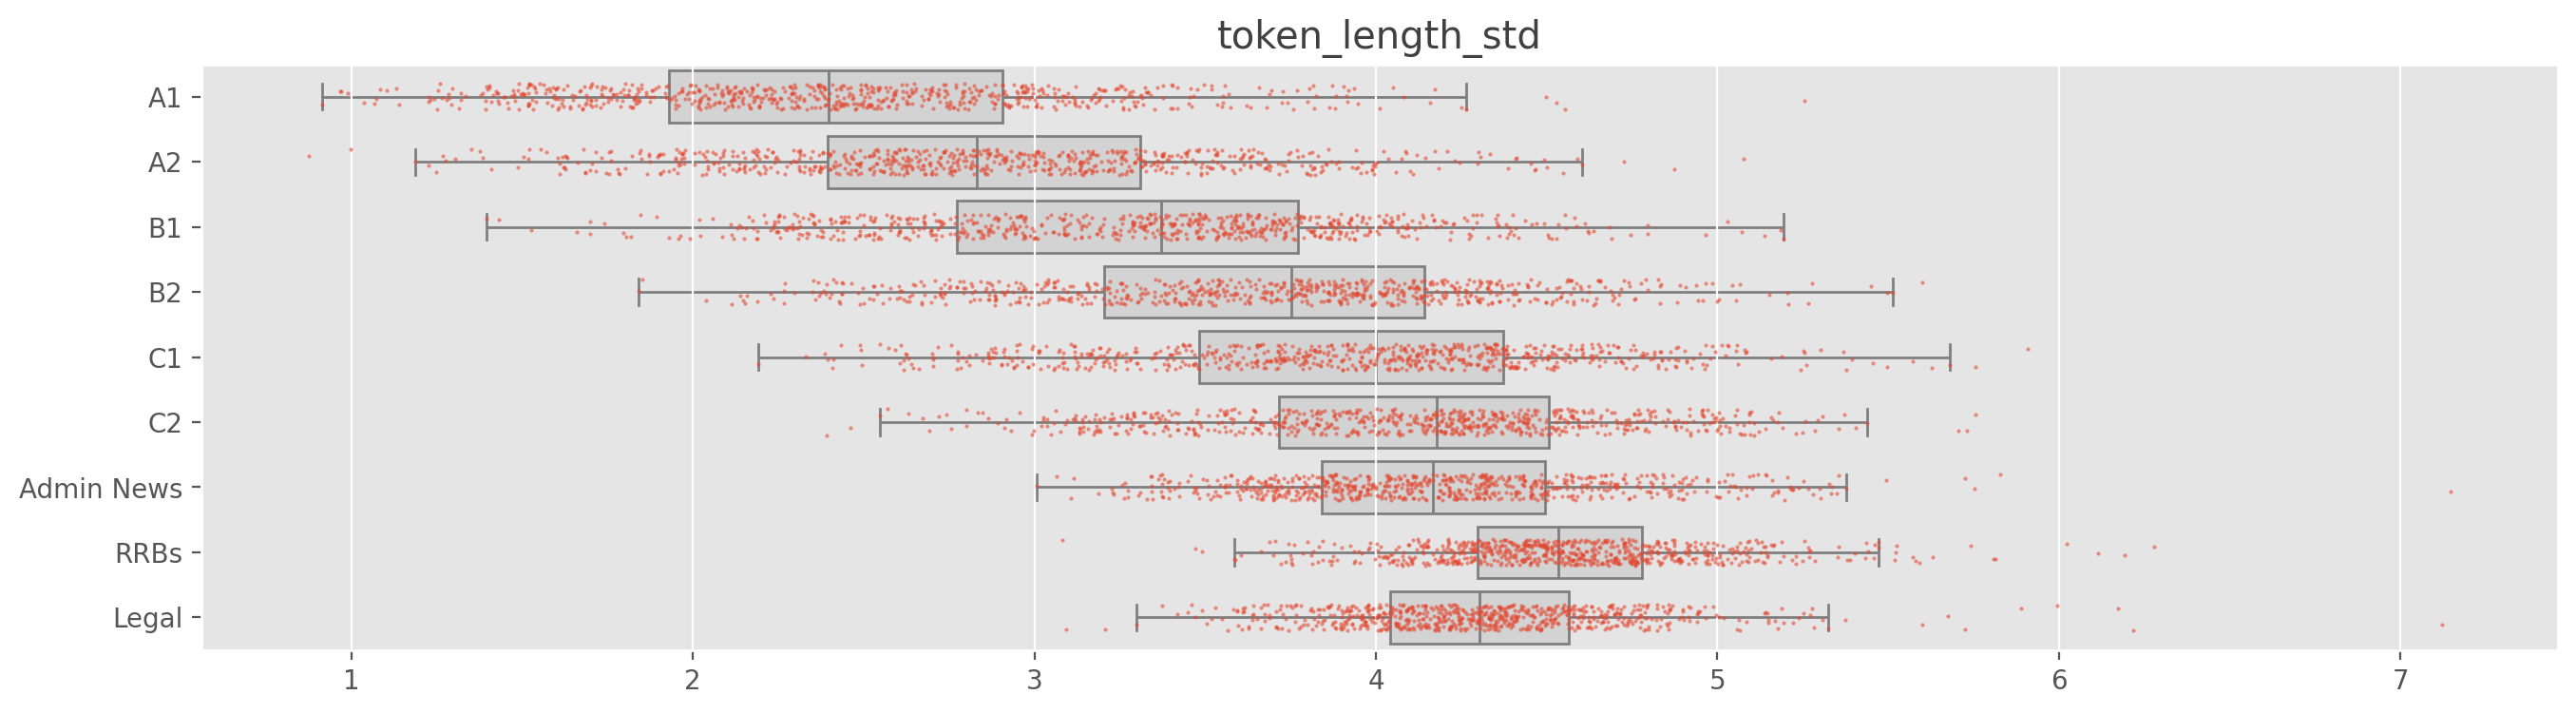

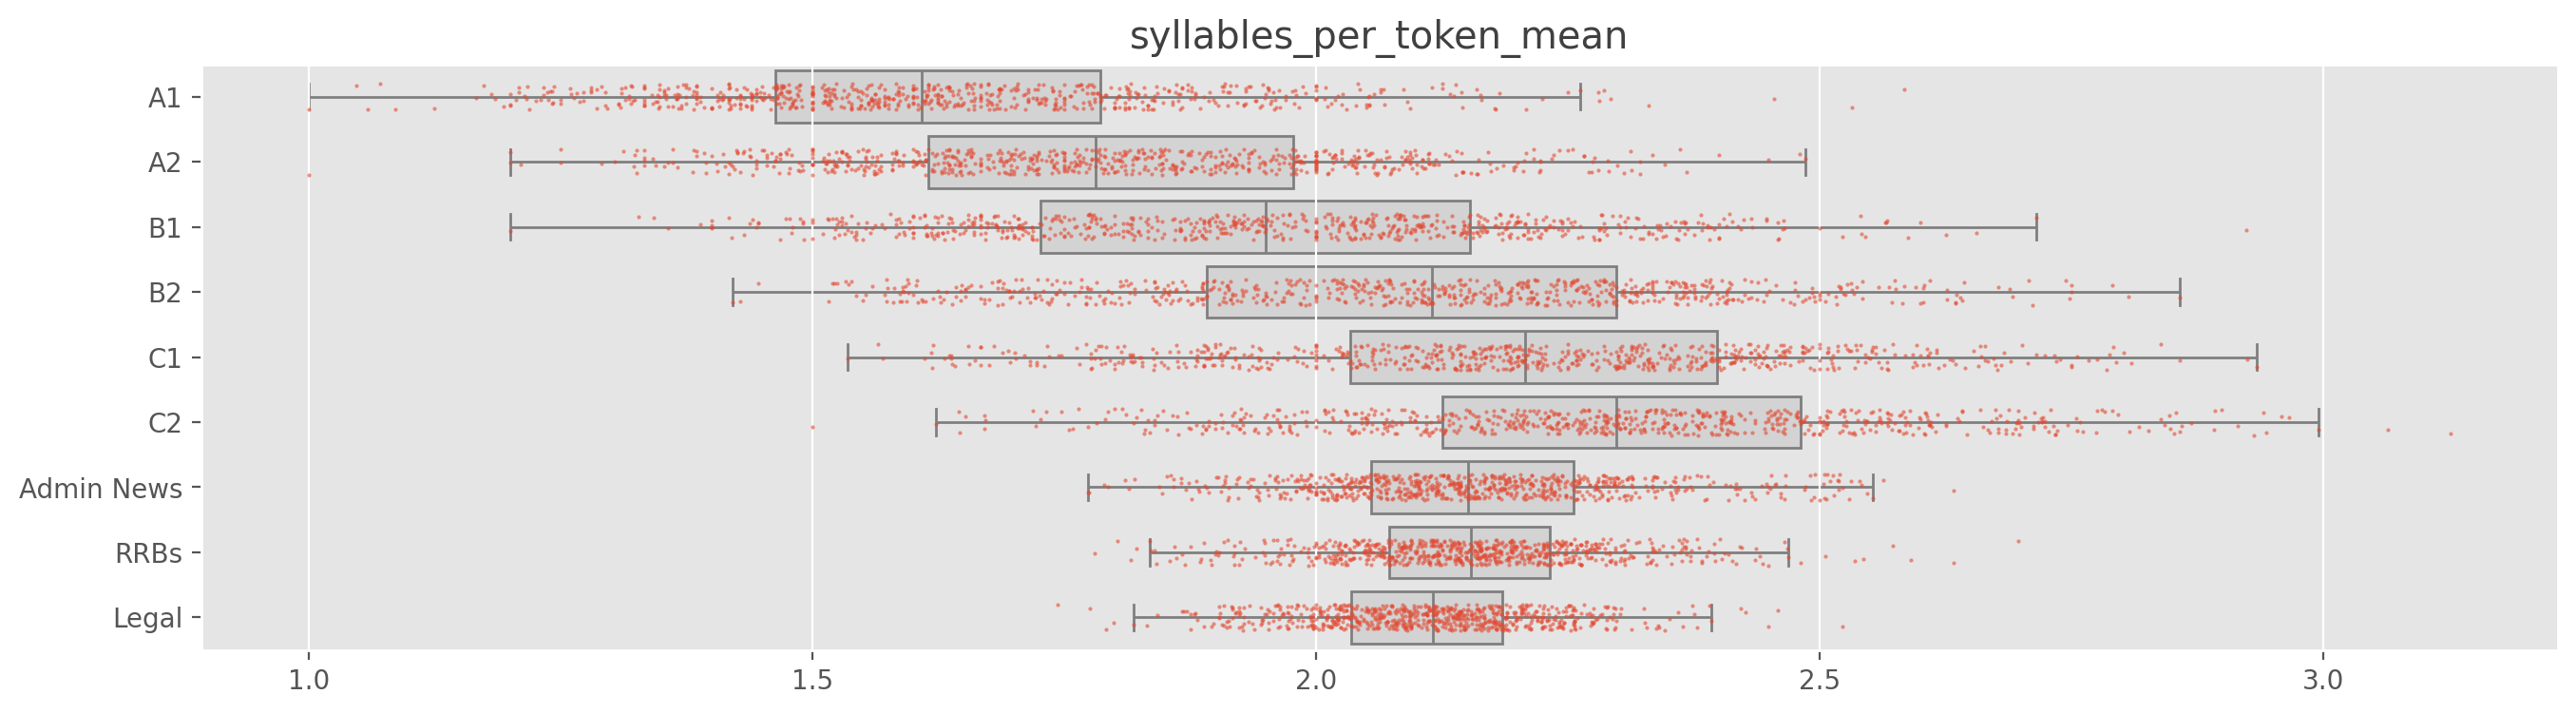

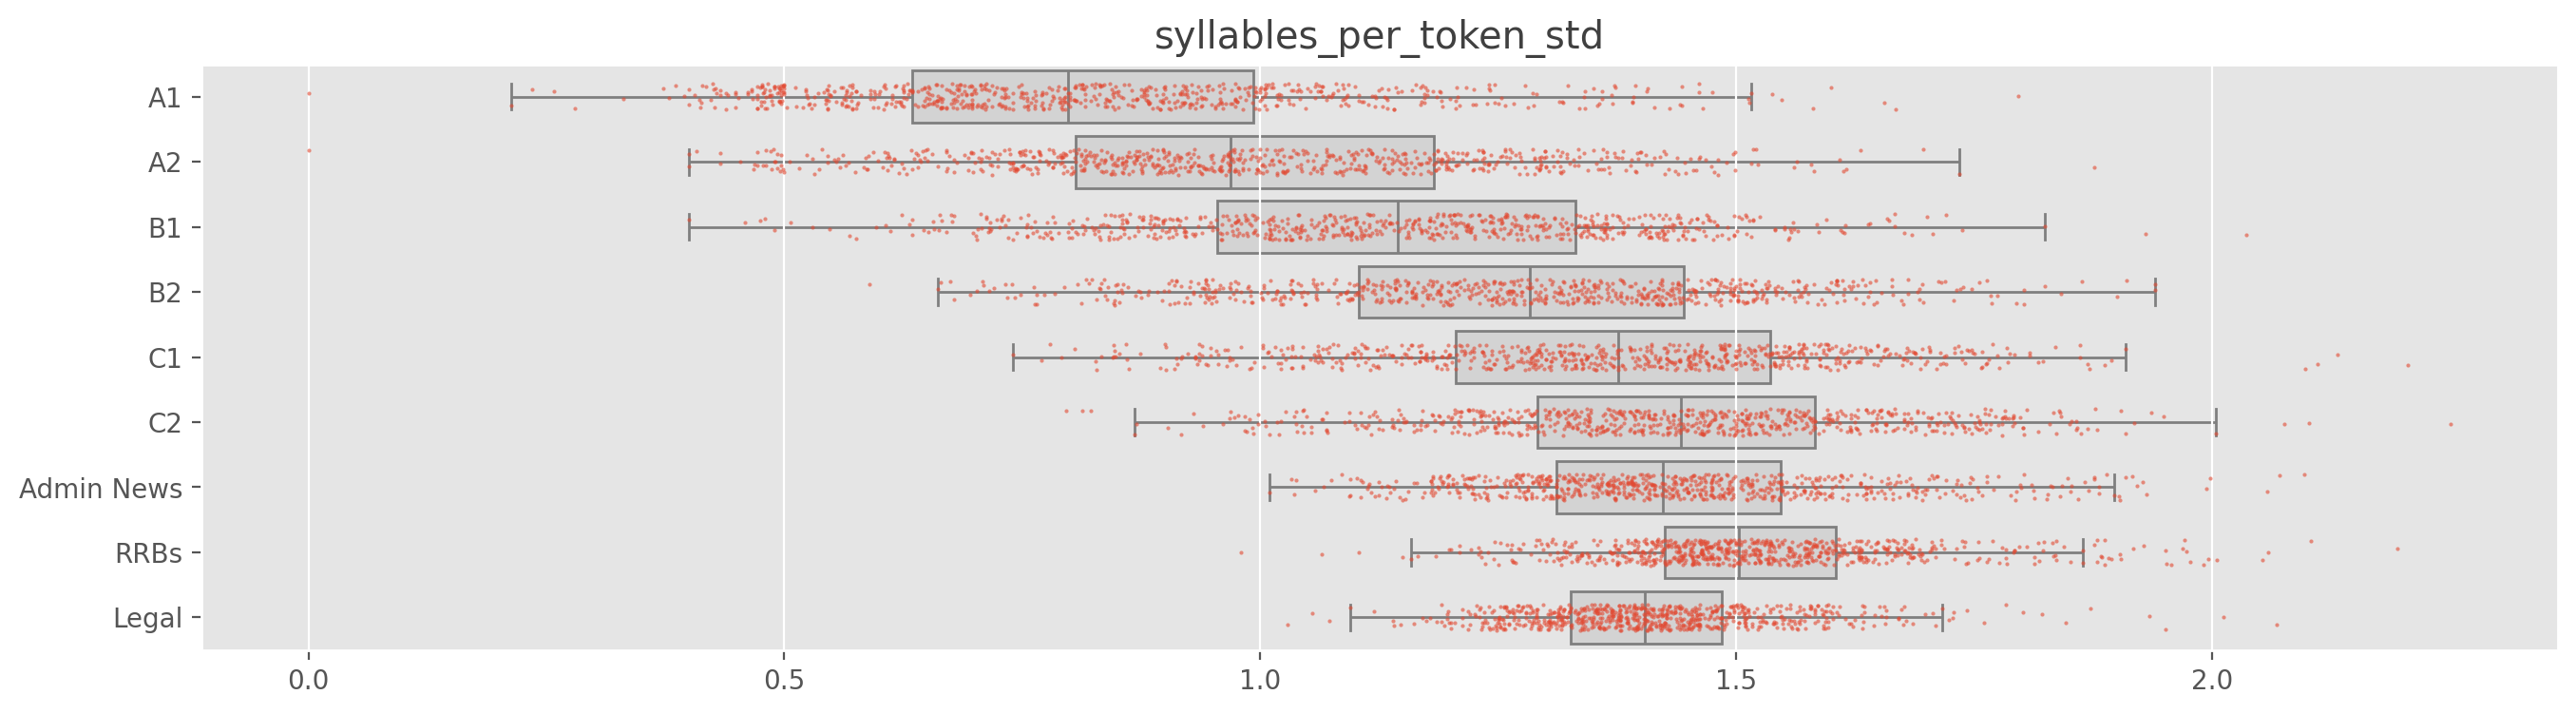

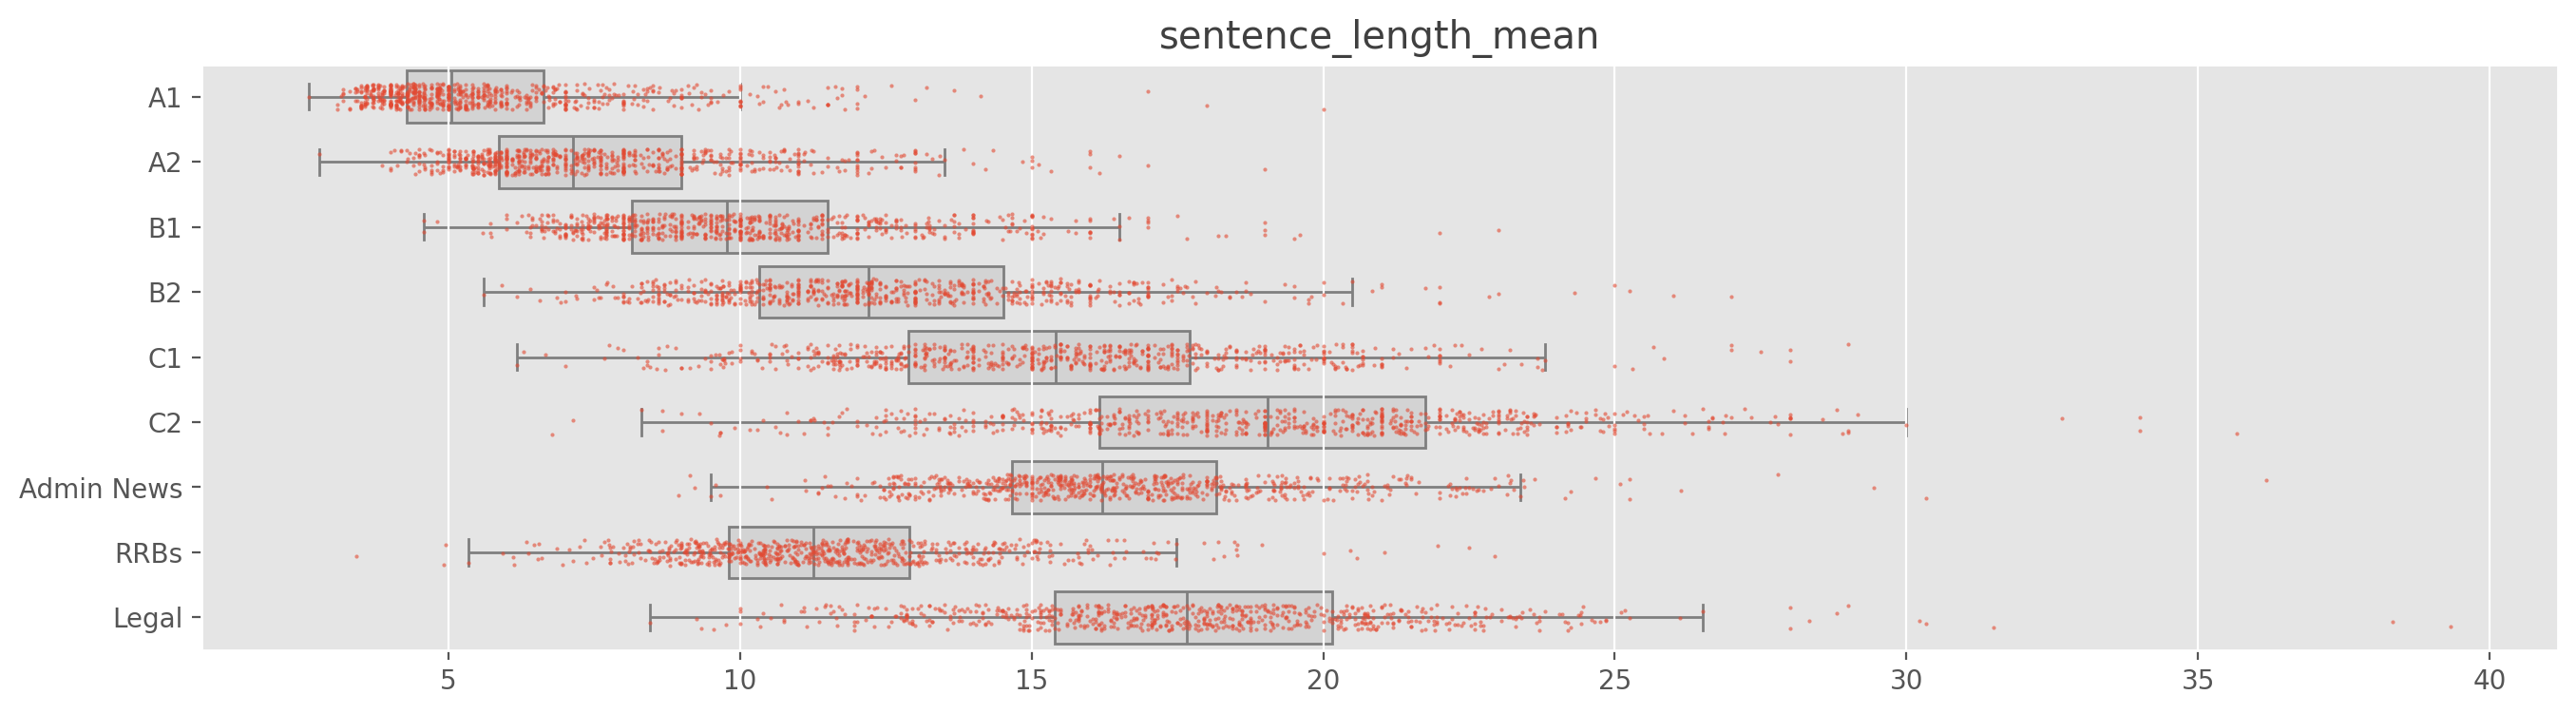

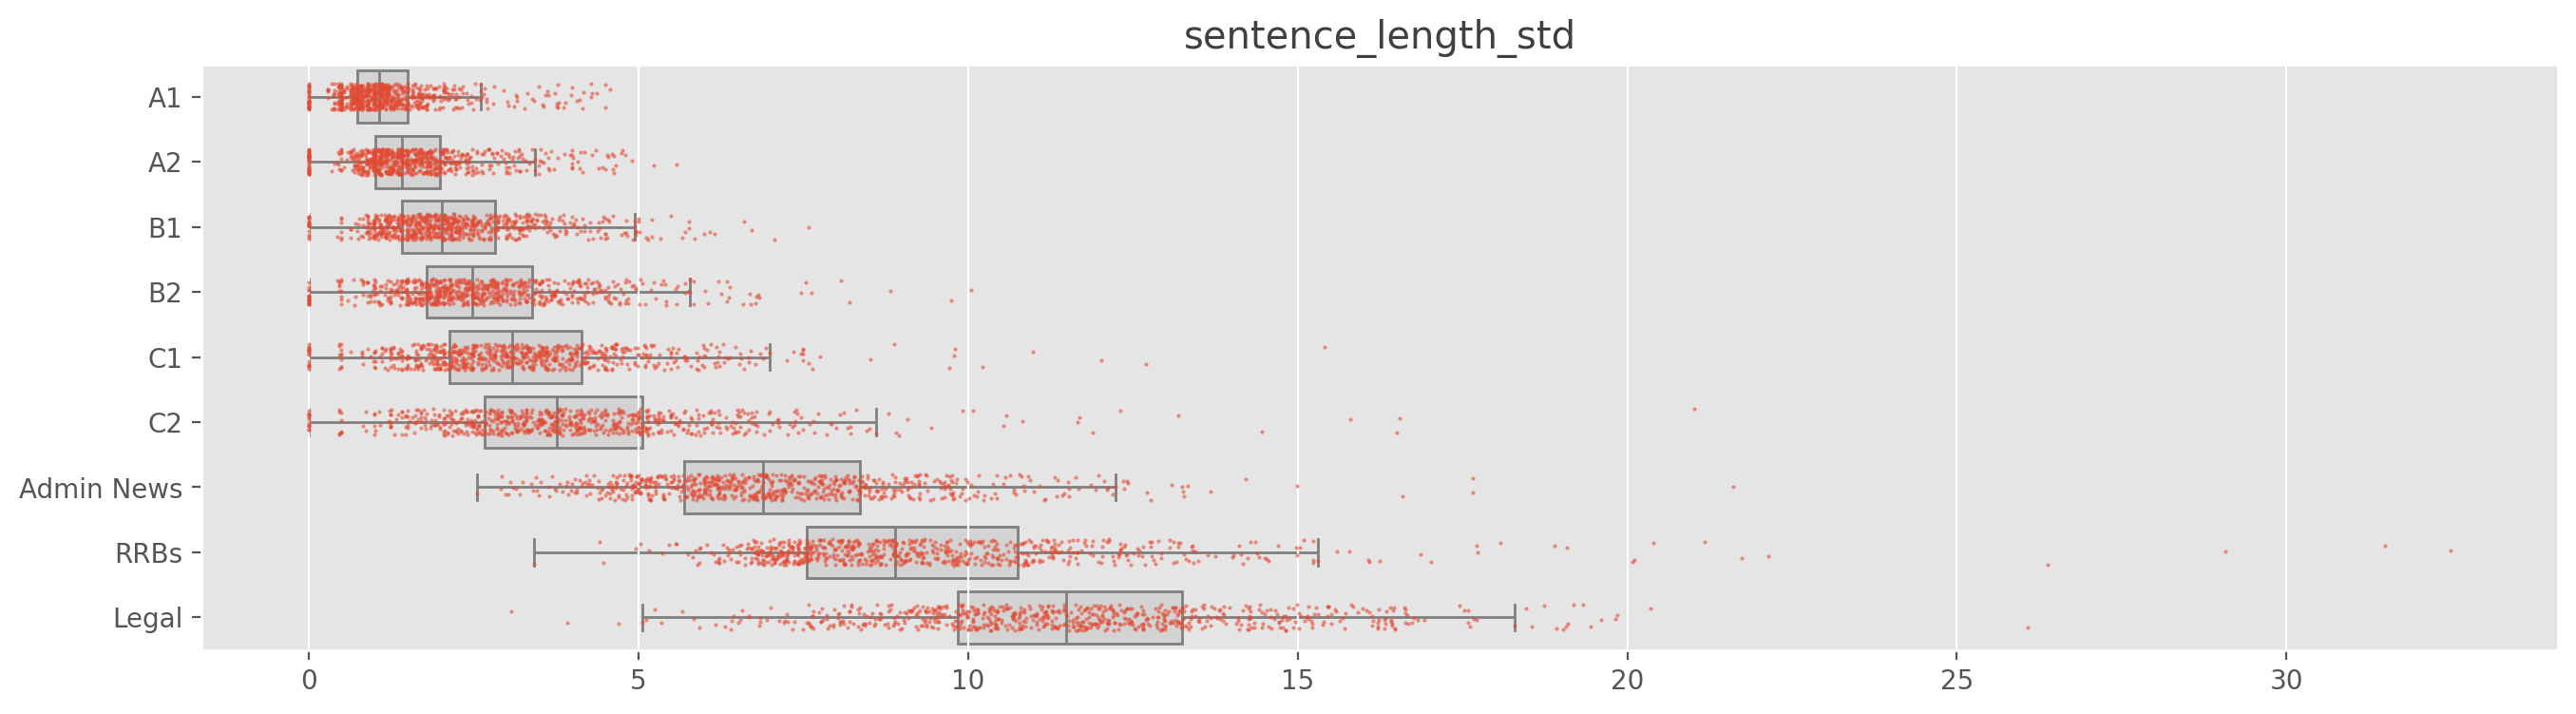

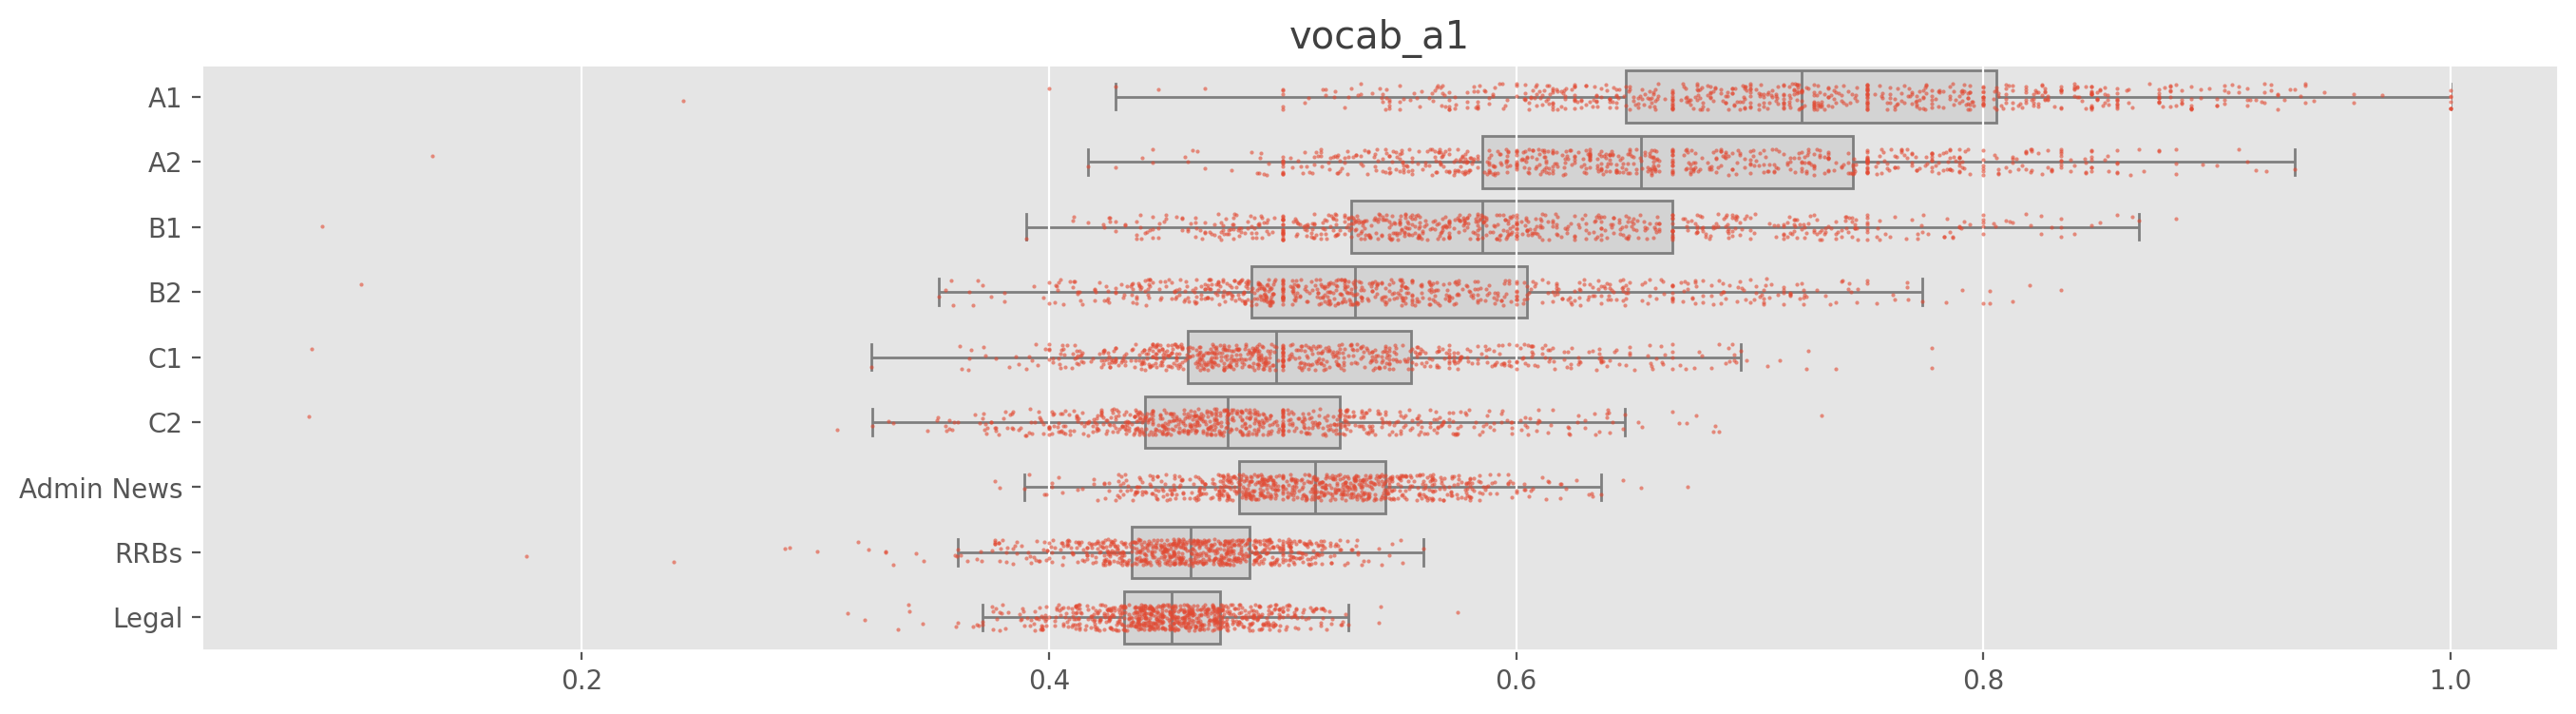

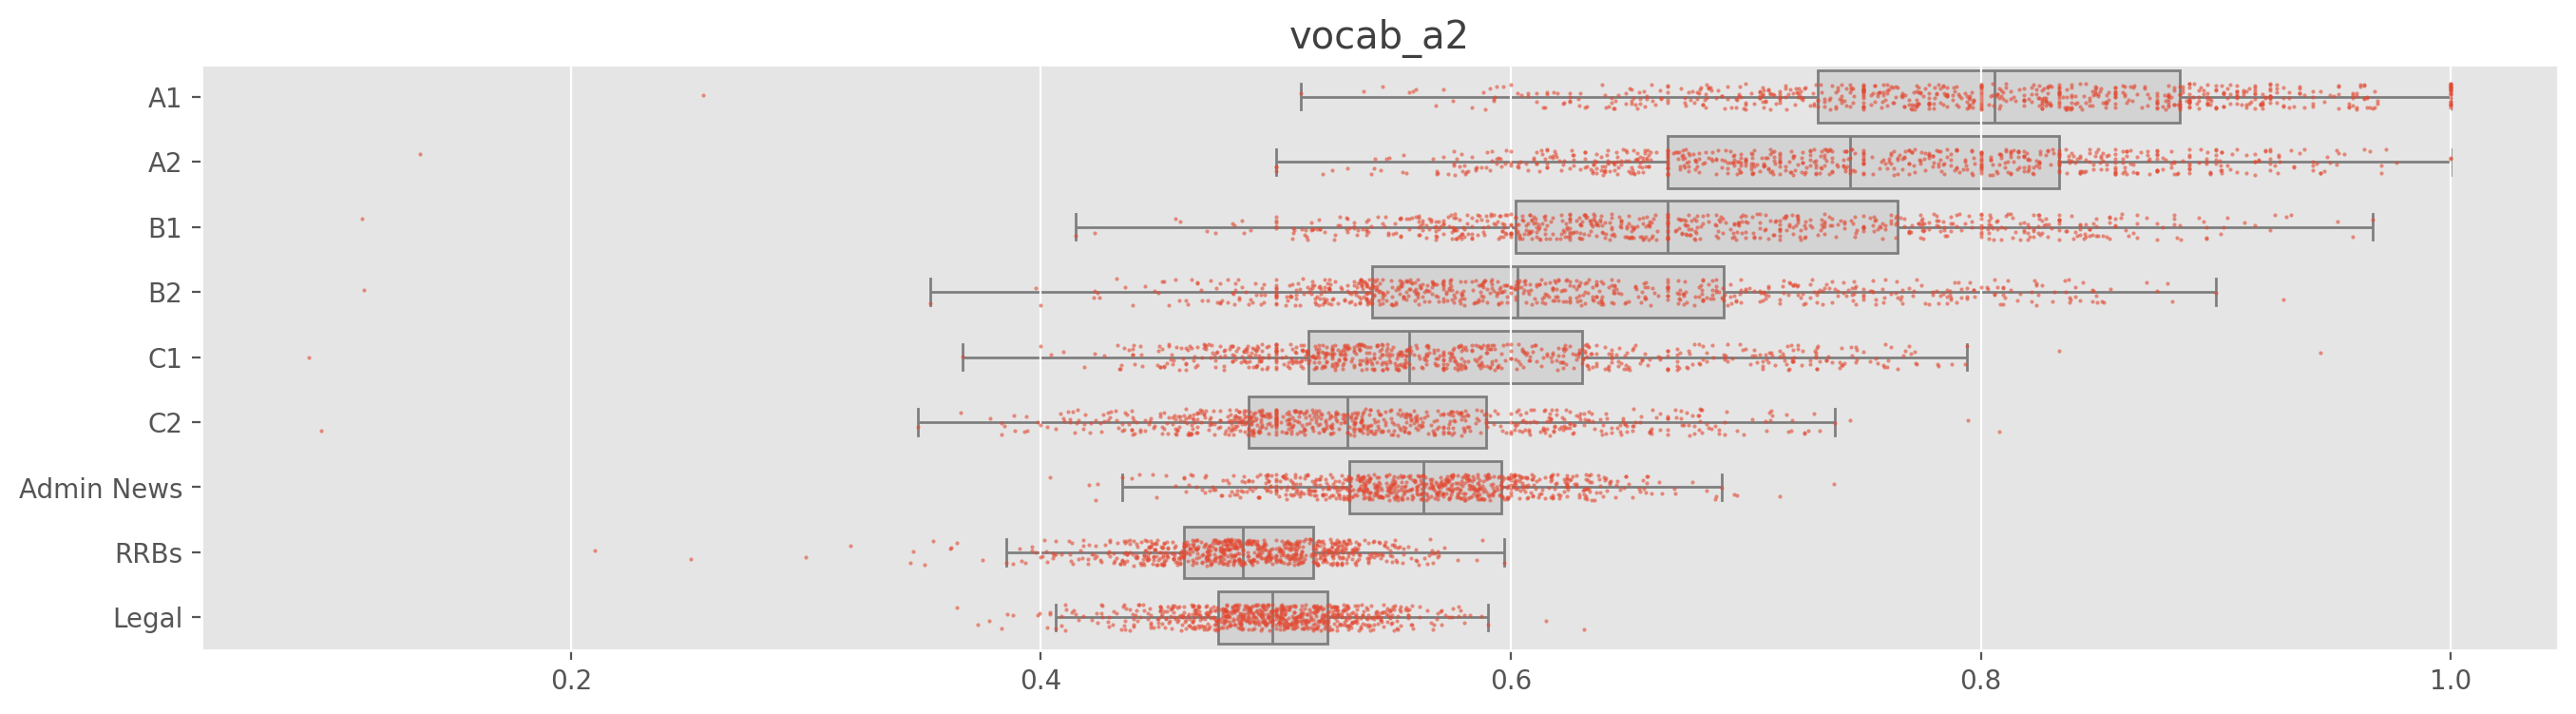

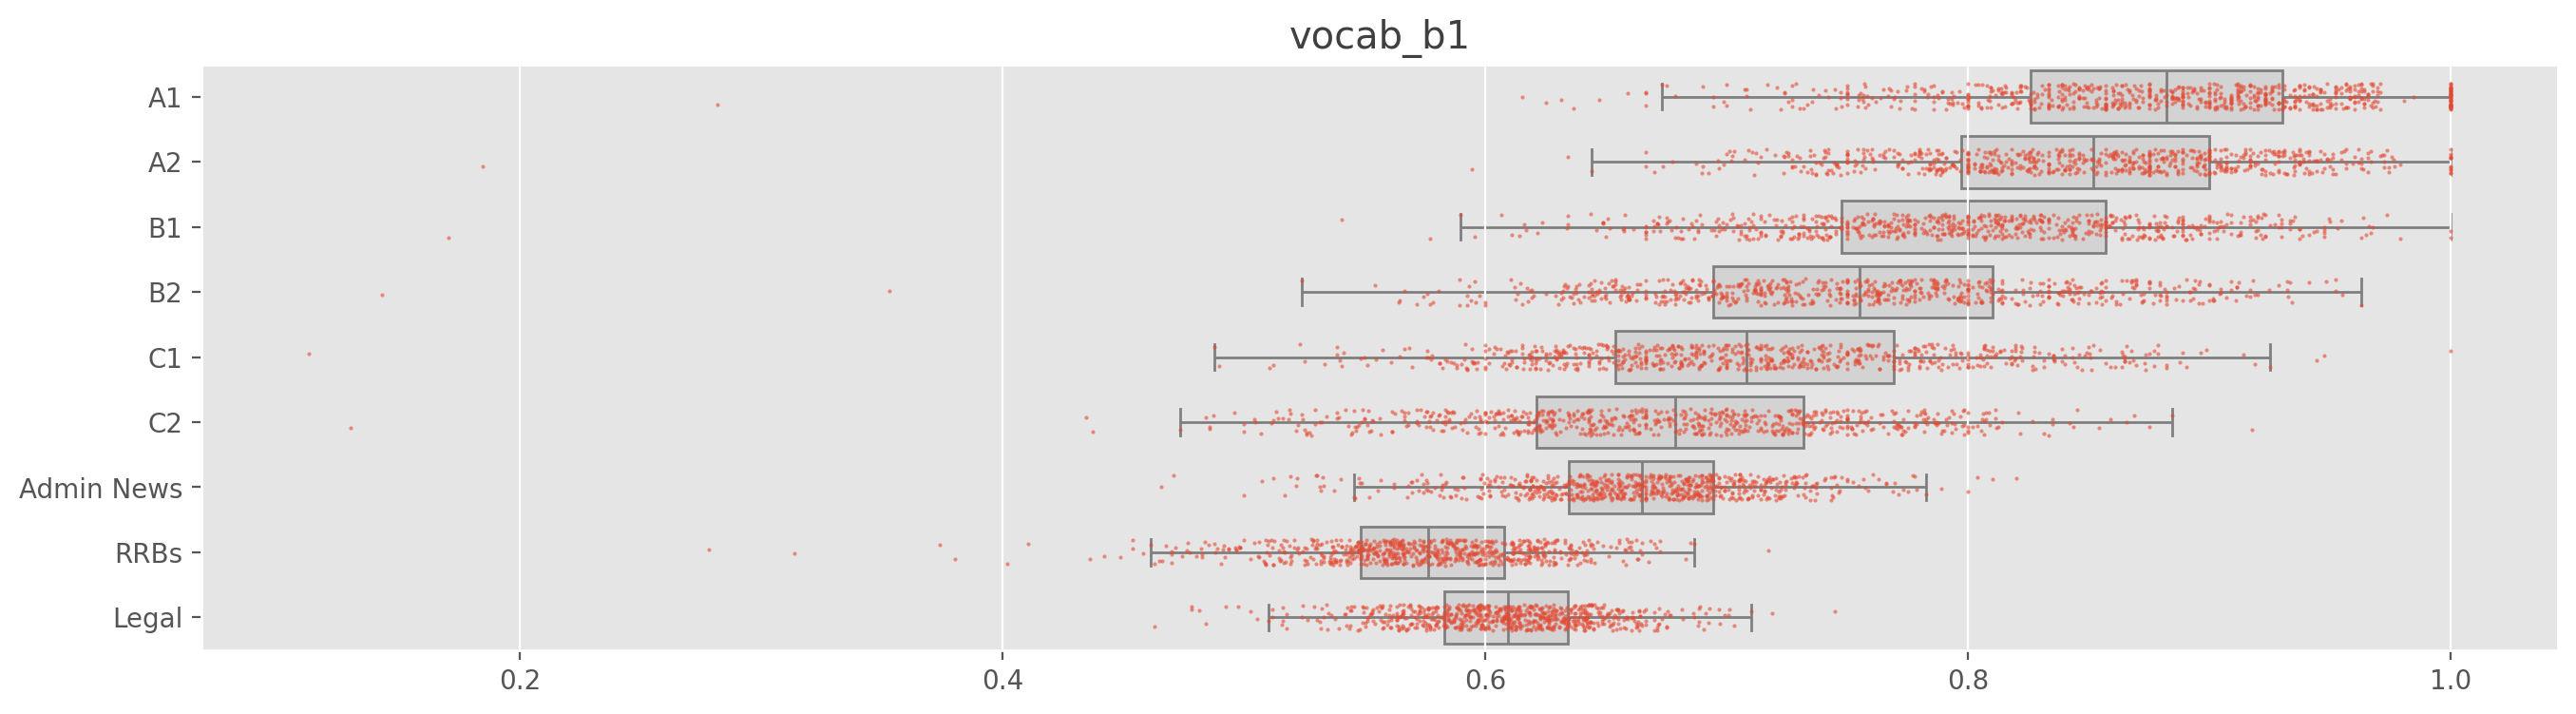

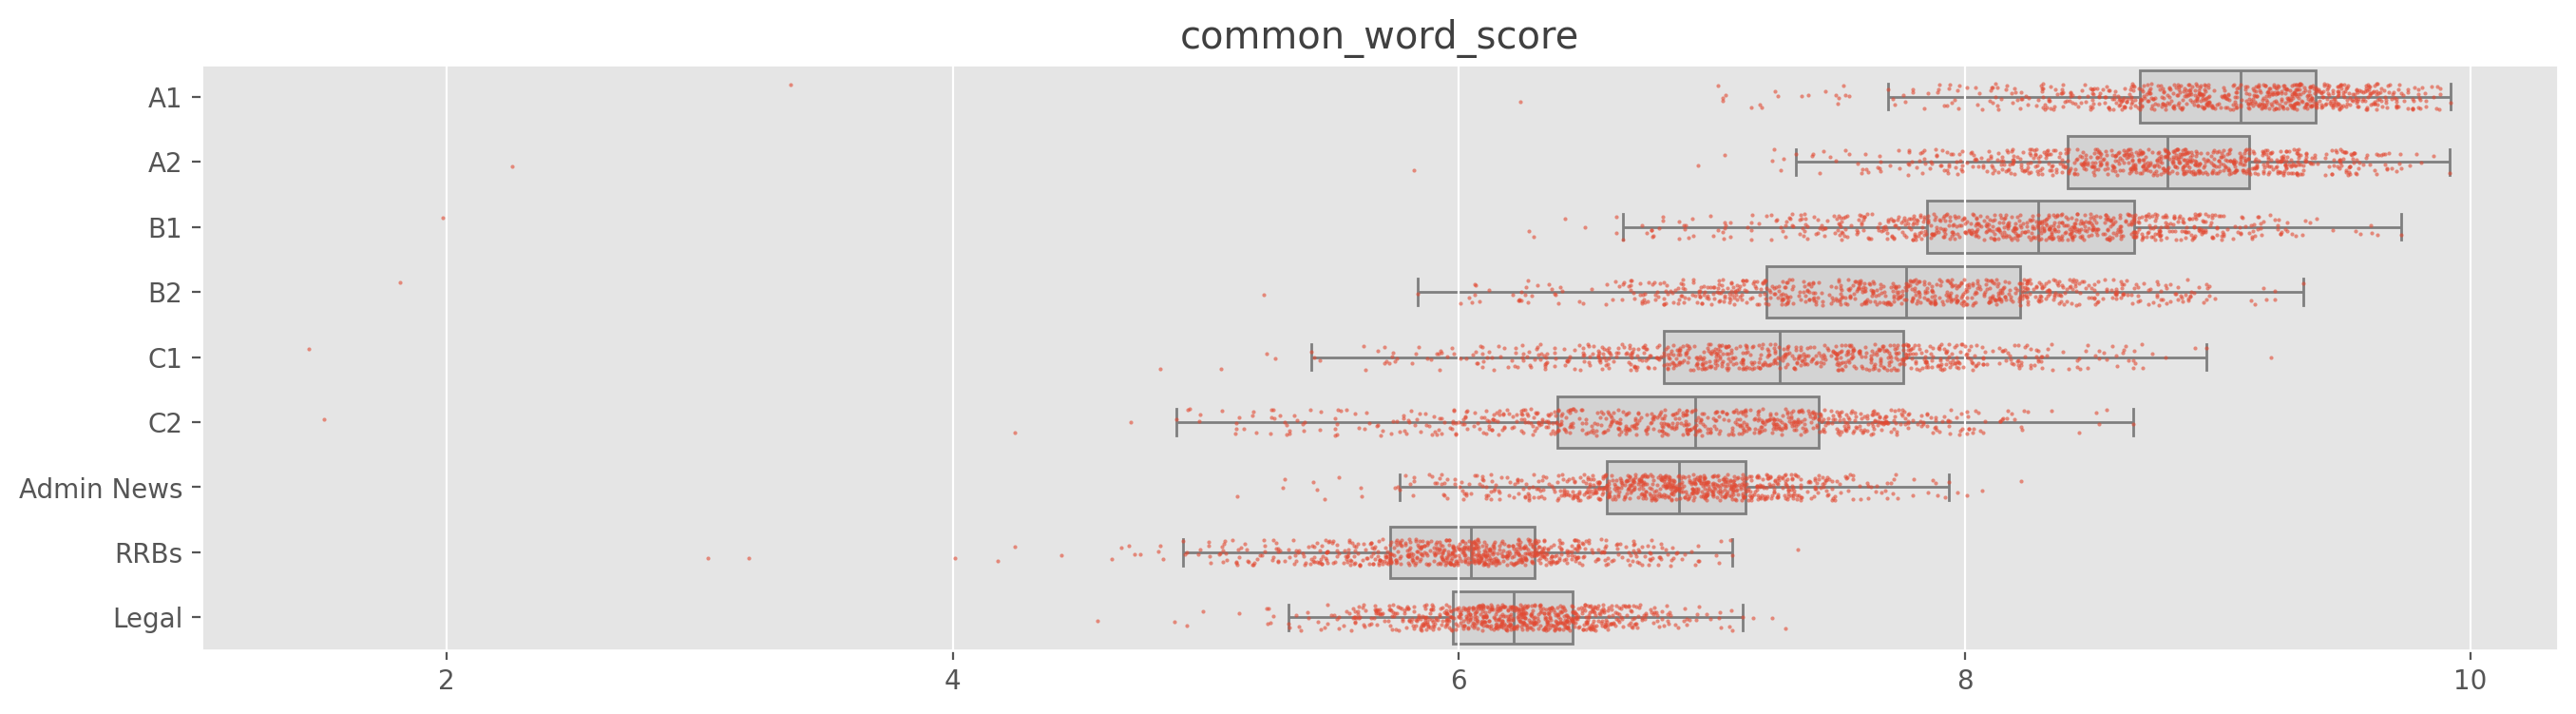

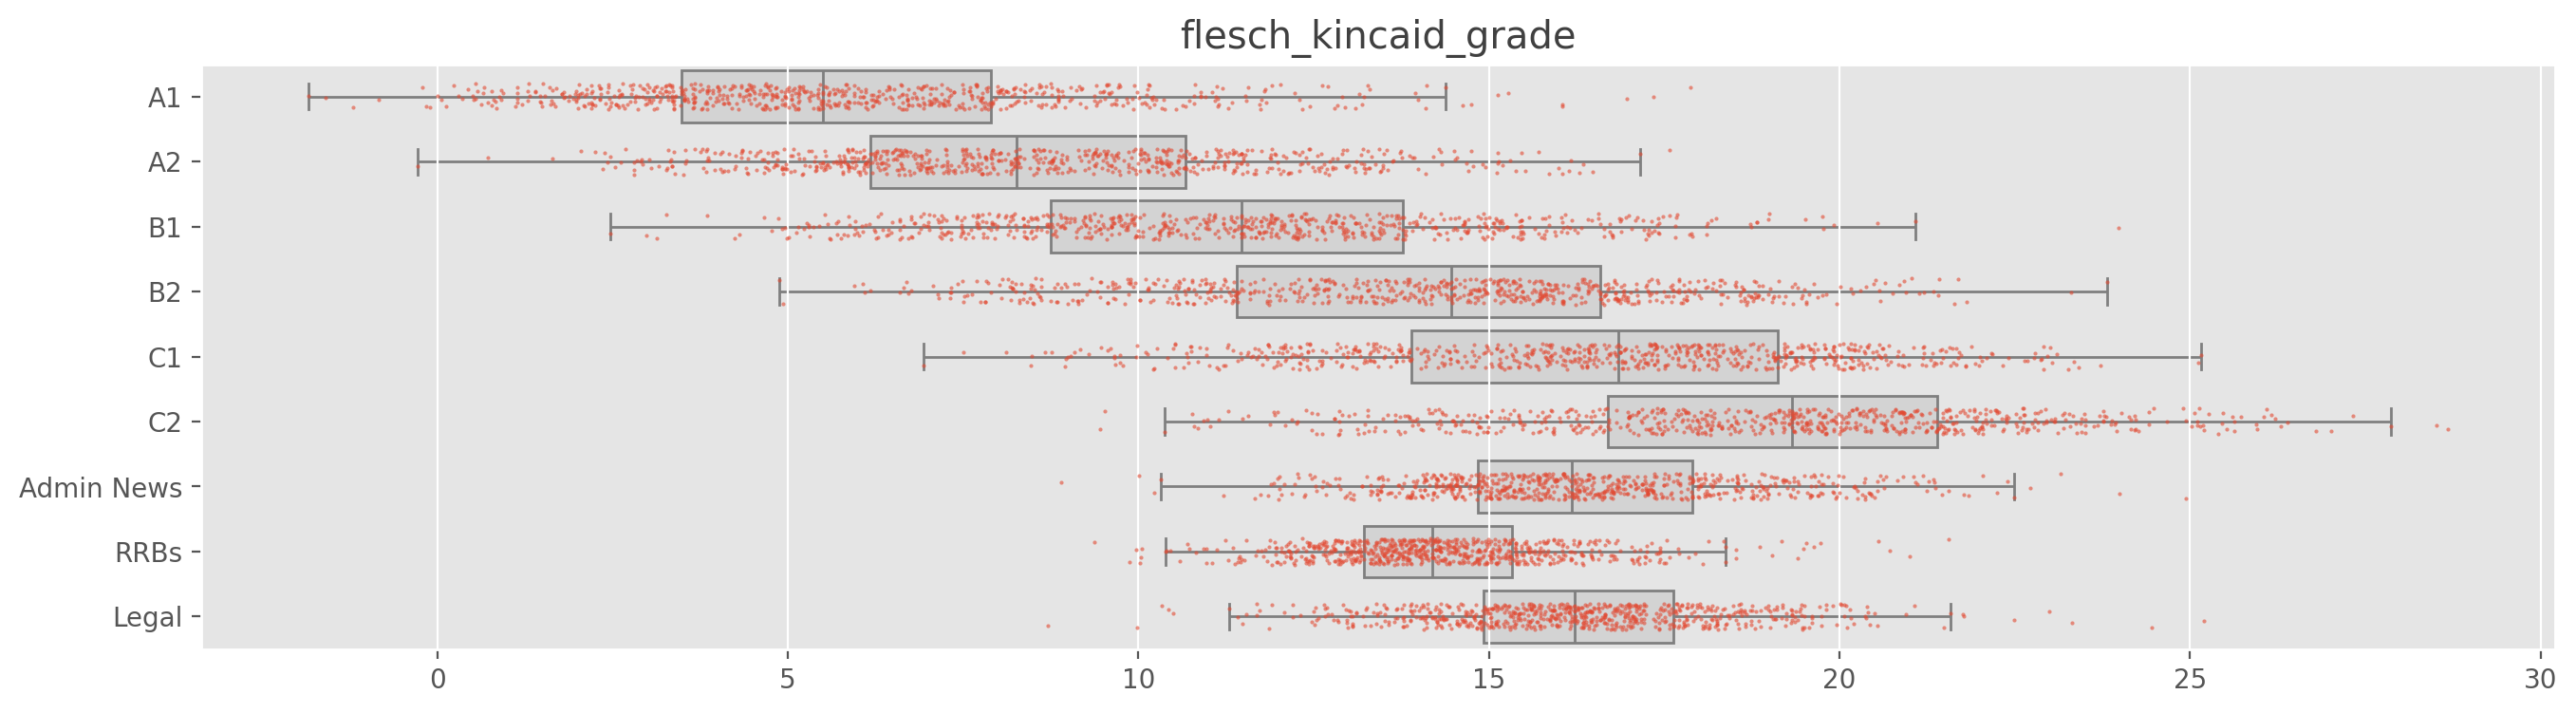

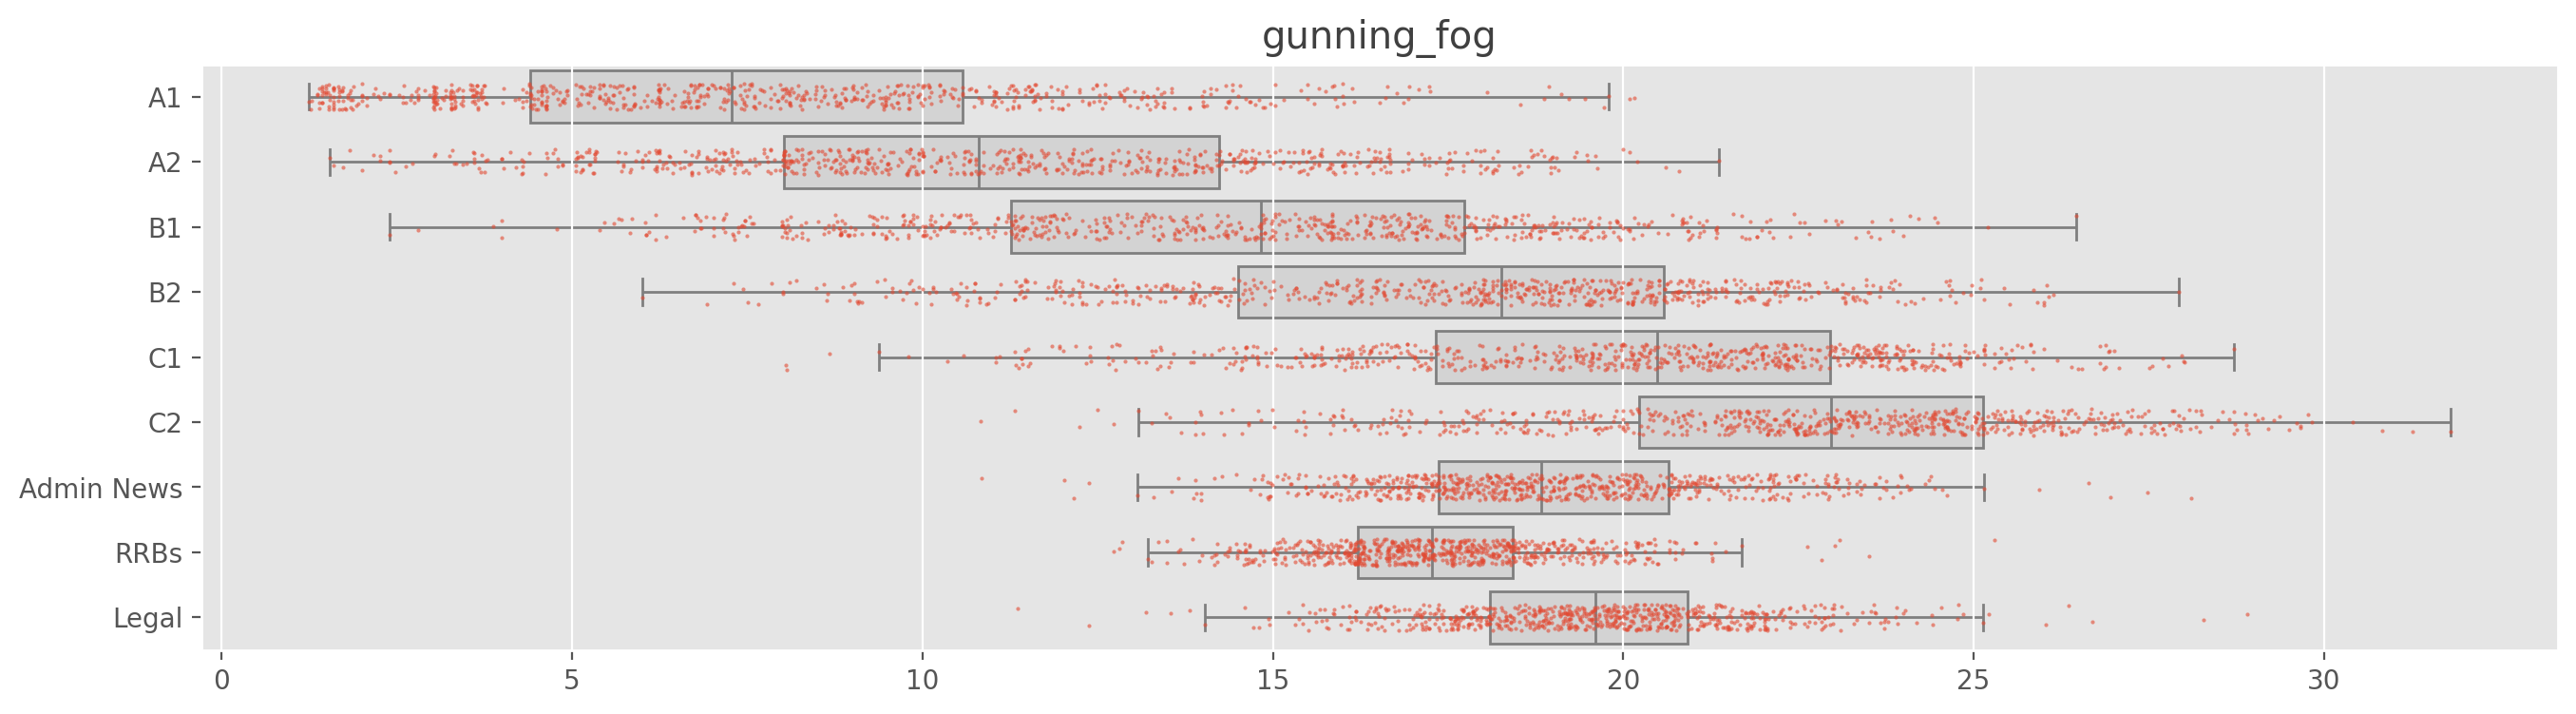

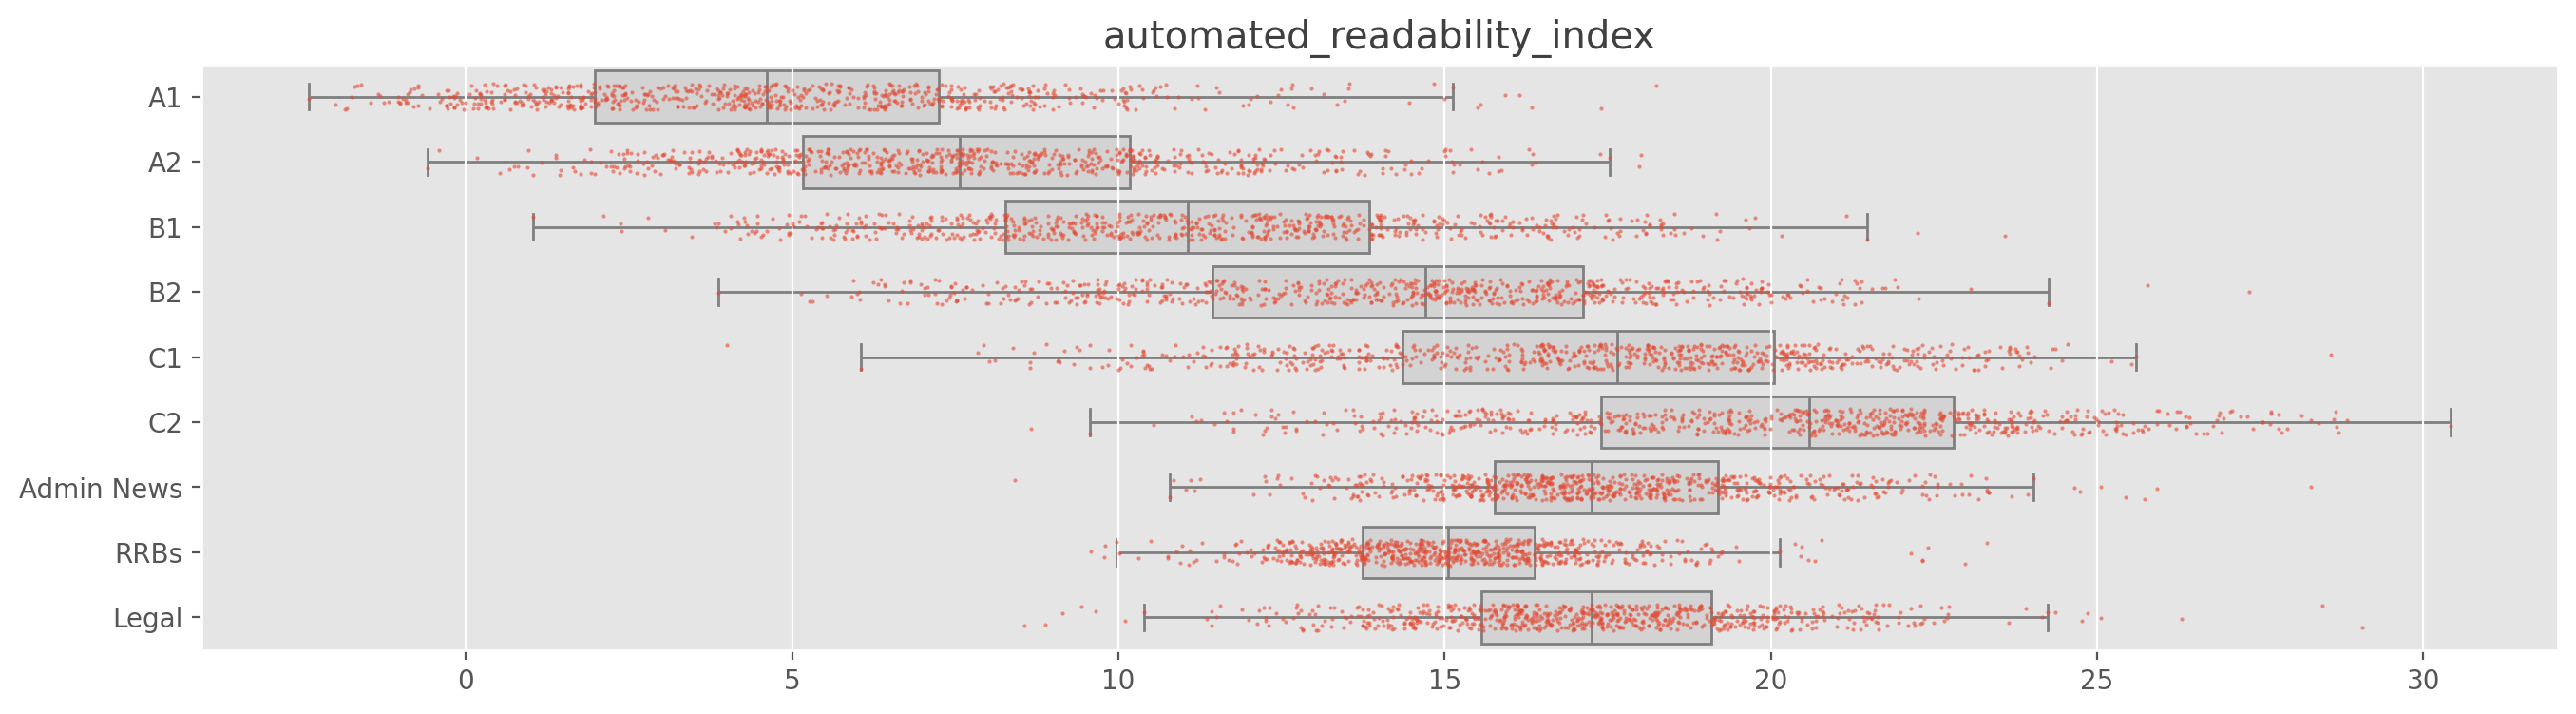

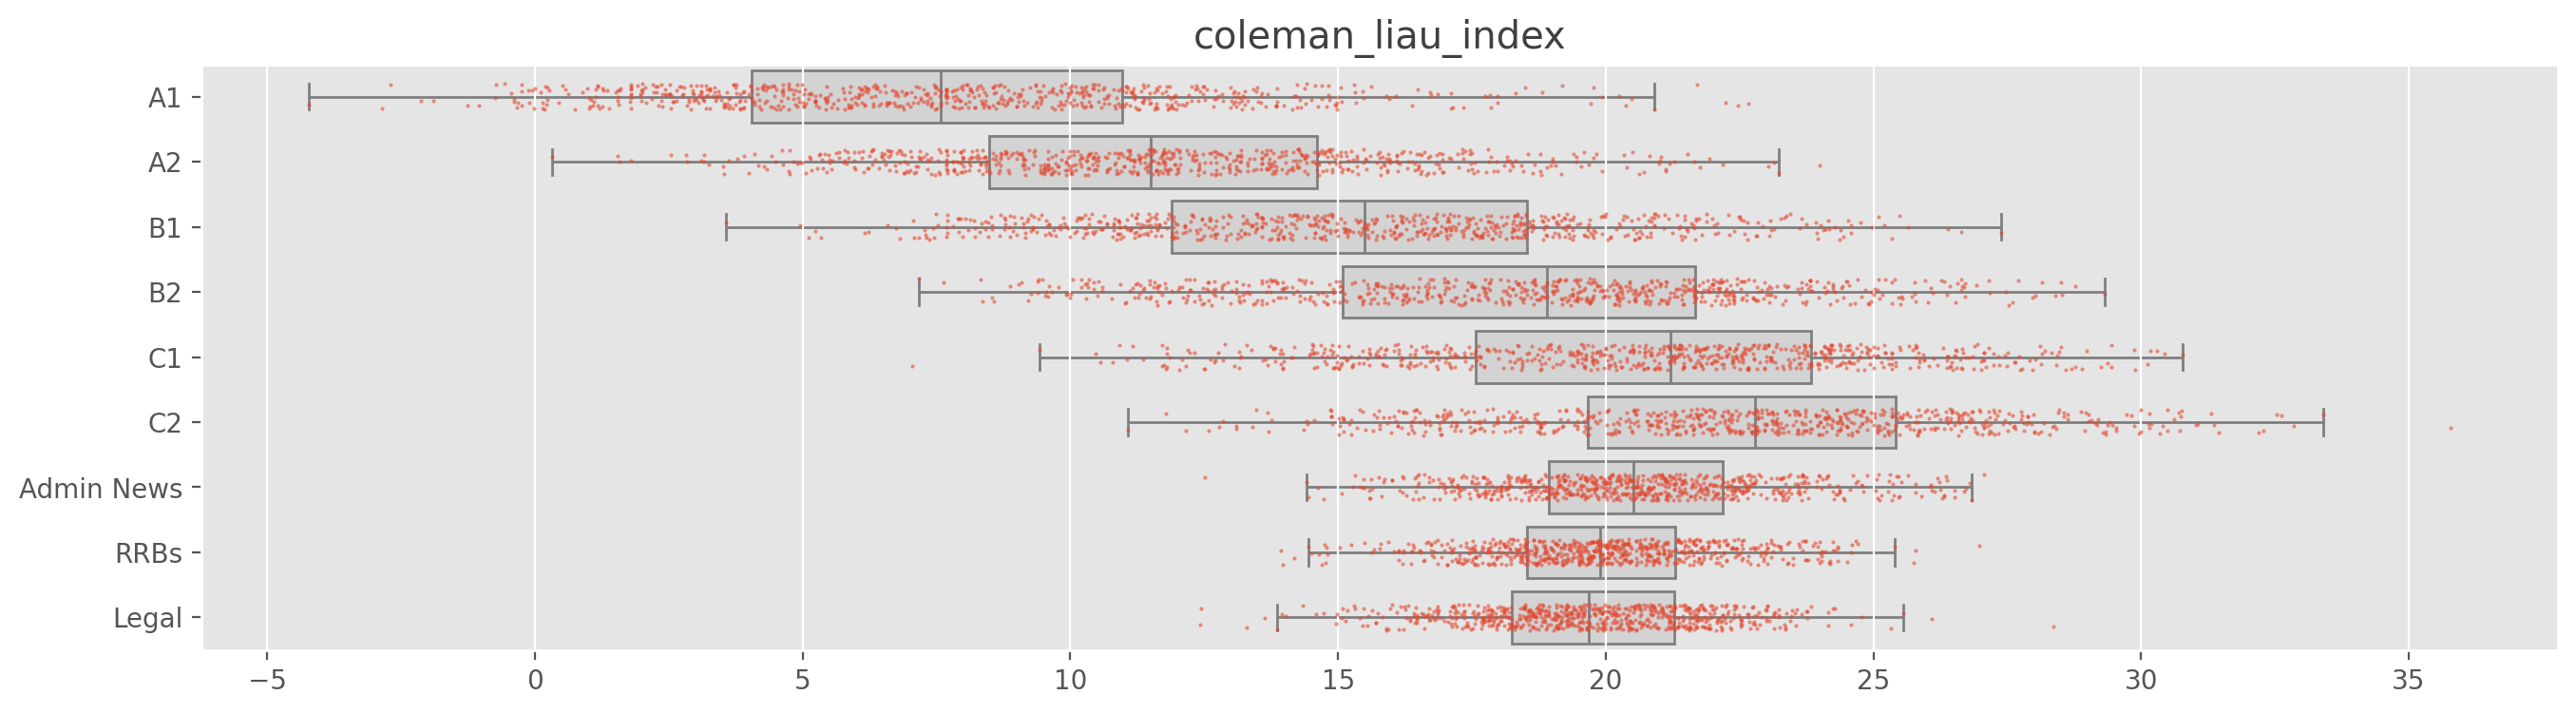

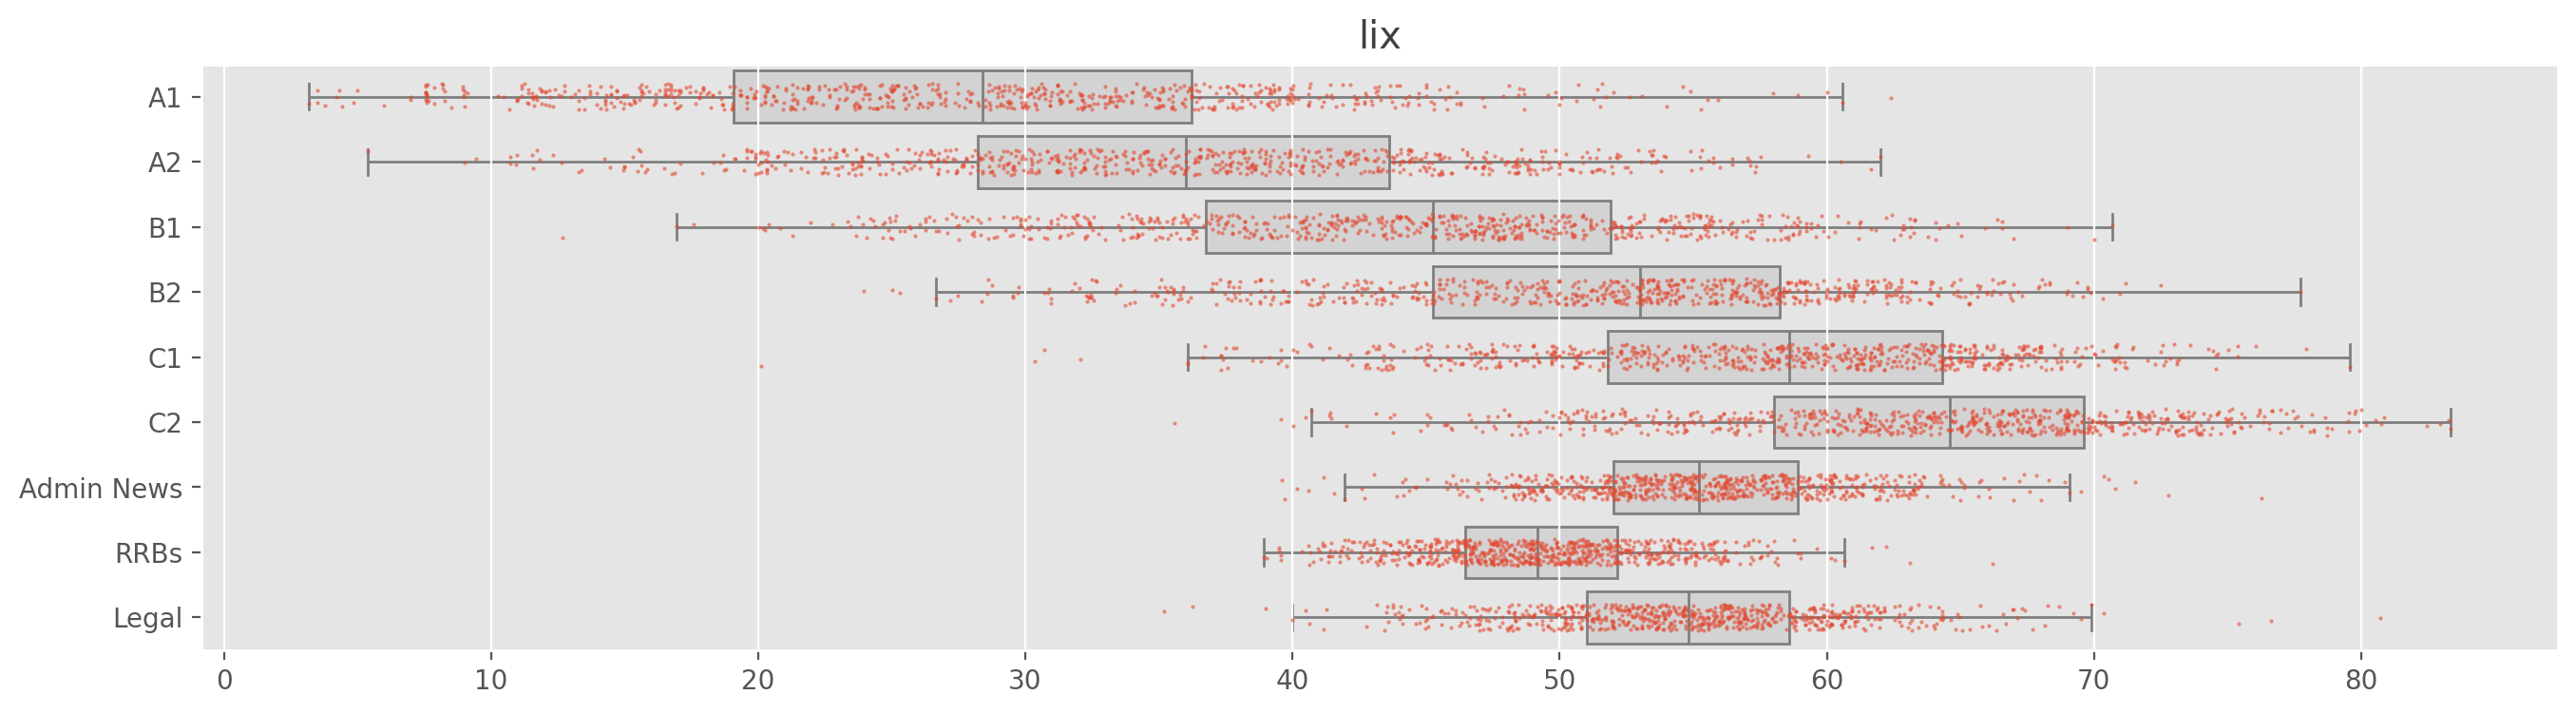

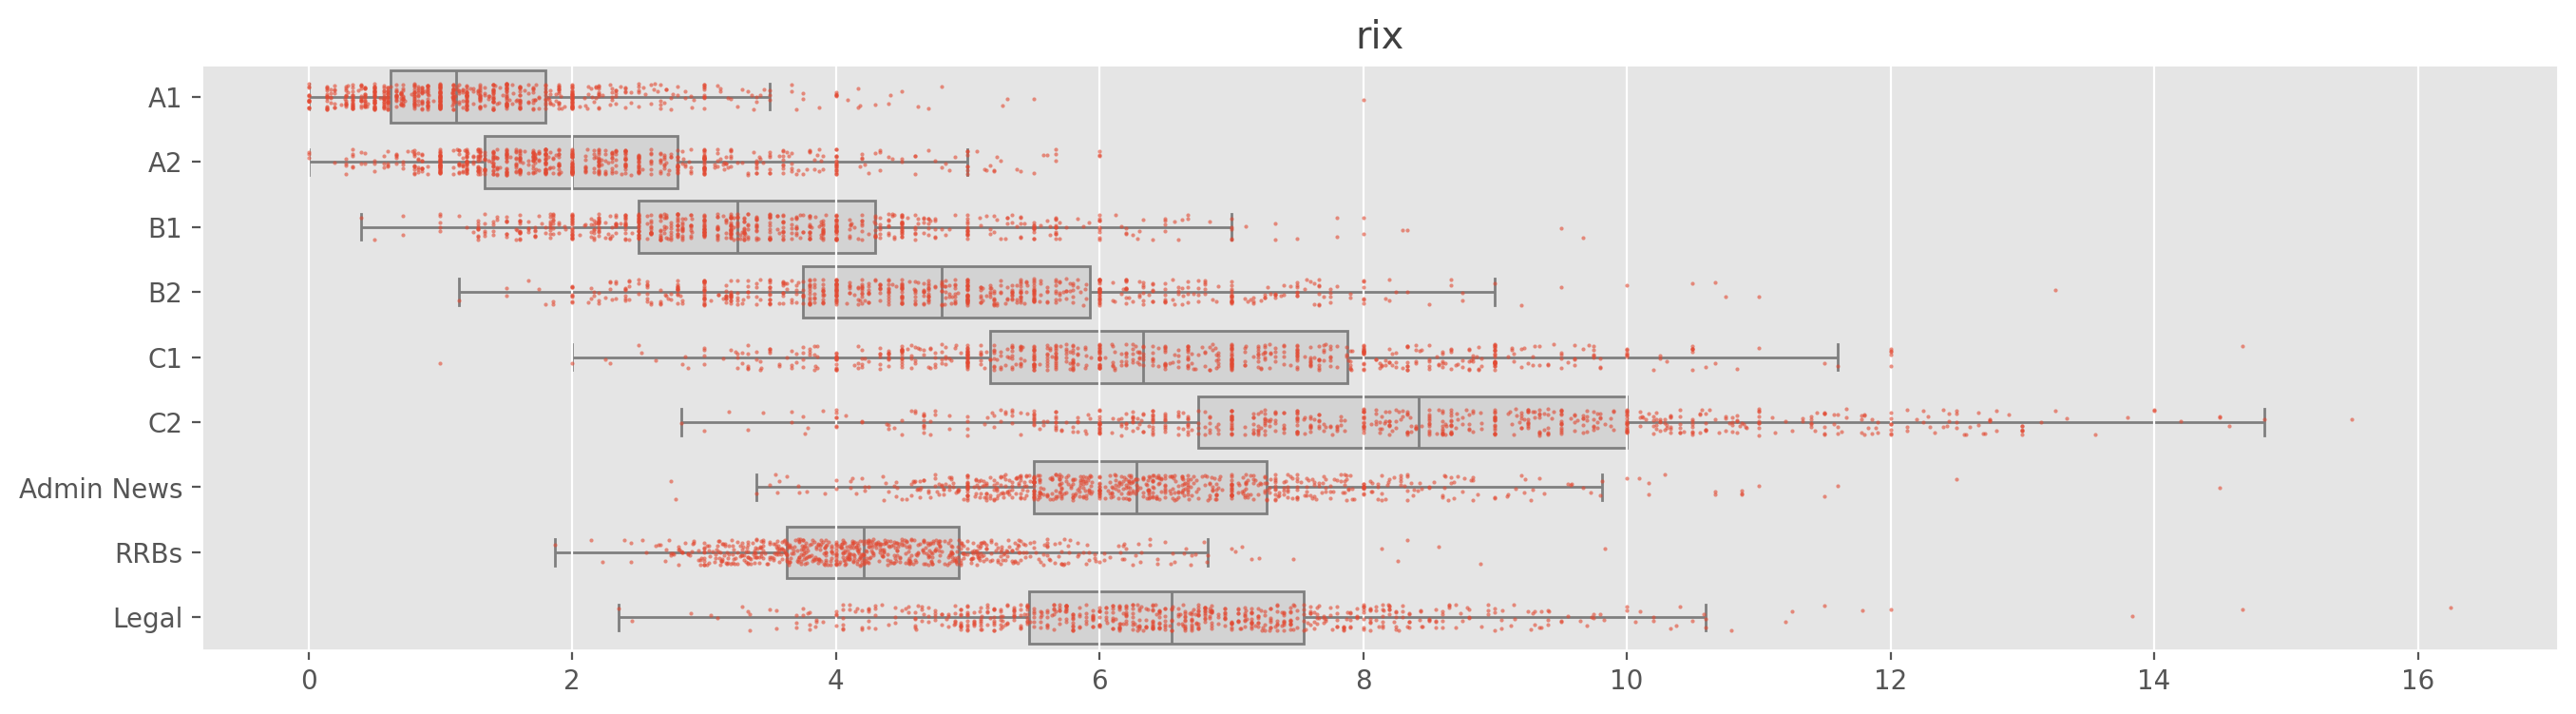

In [8]:
for col in relevant_cols:
    fig, ax = plt.subplots(figsize=(16, 4))
    sns.boxplot(
        data=df,
        x=col,
        y="text_type",
        color="lightgray",
        linewidth=1,
        ax=ax,
        order=order,
        zorder=0,
        orient="h",
        showfliers=False,
    )
    sns.stripplot(
        data=df,
        x=col,
        y="text_type",
        jitter=0.2,
        alpha=0.6,
        s=1.5,
        order=order,
        zorder=1,
        ax=ax,
        orient="h",
    )
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.show()

# Model data

Our intuition is that by combining syntactic as well as semantic features we might be able to get a sensible metric. We therefore choose a subset of apparently expressive features (2 syntactic, 4 semantic).

In [29]:
final_cols = [
    "sentence_length_mean",
    "rix",
    "vocab_a1",
    "vocab_a2",
    "vocab_b1",
    "common_word_score",
]

We also add interaction terms. This forces the model to use syntactic and semantic features at the same time. 

In [30]:
df["rix_cws"] = df["rix"] * df["common_word_score"]
df["rix_vocab_a1"] = df["rix"] * df["vocab_a1"]
df["rix_vocab_a2"] = df["rix"] * df["vocab_a2"]
df["rix_vocab_b1"] = df["rix"] * df["vocab_b1"]
df["slm_cws"] = df["sentence_length_mean"] * df["common_word_score"]
df["slm_vocab_a1"] = df["sentence_length_mean"] * df["vocab_a1"]
df["slm_vocab_a2"] = df["sentence_length_mean"] * df["vocab_a2"]
df["slm_vocab_b1"] = df["sentence_length_mean"] * df["vocab_b1"]

In [31]:
final_cols_extended = final_cols + [
    "rix_cws",
    "rix_vocab_a1",
    "rix_vocab_a2",
    "rix_vocab_b1",
    "slm_cws",
    "slm_vocab_a1",
    "slm_vocab_a2",
    "slm_vocab_b1",
]

Now we map our text types to a regression target value according to the assumed language levels. This again involves educated guesses. We do not have ground truth here.
- We map the CEFR levels of our synthetic samples to a scale from 1 to 6.
- We assume that RRBs and administrative news lie between C1 and C2.
- We assume that our legal texts are more difficult than C2 synthetic samples. We assign a difficulty value of 7.

In [12]:
mapping = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "Admin News": 5.5,
    "RRBs": 5.5,
    "C2": 6,
    "Legal": 7,
}

df["difficulty"] = df.text_type.map(mapping)

Let's first model the data with a [Gaussian Mixture model](https://scikit-learn.org/stable/modules/mixture.html#gaussian-mixture-models) so that we can identify outliers.

The idea for this stems from [Vincent Warmerdams](https://koaning.io/) several excellent talks and tutorials, most specifically from this live coding session [«Expanding on GMMs»](https://www.youtube.com/watch?v=821aPPsFPsY).

In [13]:
# We set the components to 28 since we have 14 features.
# We assume that two Gaussian components are sufficient per feature.
gmm = GaussianMixture(n_components=28, random_state=42)
gmm.fit(df[final_cols_extended])
df["log_likelihood"] = gmm.score_samples(df[final_cols_extended])

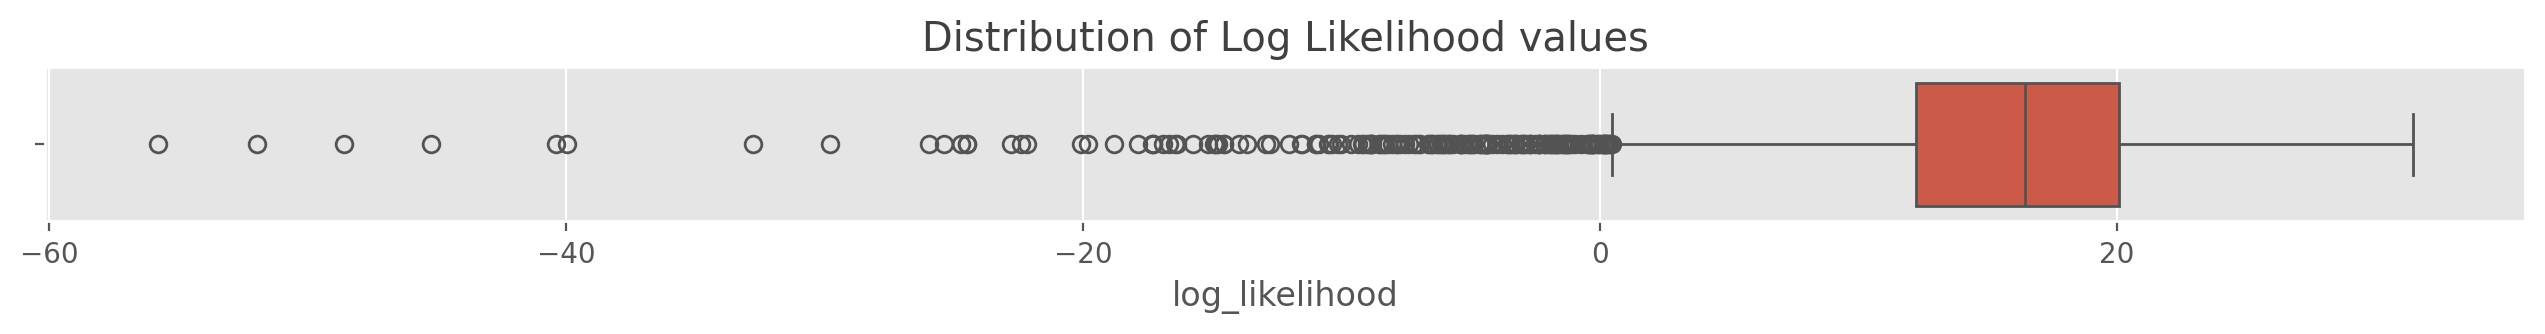

In [14]:
fig, ax = plt.subplots(figsize=(16, 1))
sns.boxplot(data=df, x="log_likelihood", showfliers=True)
ax.set_title("Distribution of Log Likelihood values")
plt.show()

We just keep the 75% samples with the highest probability of belonging to our modeled gaussian mixture distribution. 

In [15]:
q_limit = 0.25
q = np.quantile(df.log_likelihood, q_limit)
print(f"Quantile {q_limit}: {q:.2f}")
df_outlier = df[df.log_likelihood <= q]
df_inlier = df.loc[~df.index.isin(df_outlier.index)]

Quantile 0.25: 12.21


We check the most extreme outliers according to our GMM modeling. Among these are very few samples in French. These are synthetic samples about French as a school subject.

In [16]:
for text, text_type, score in (
    df_outlier.sort_values("log_likelihood", ascending=True)[
        ["text", "text_type", "log_likelihood"]
    ]
    .head(20)
    .values
):
    print(f"Type: {text_type} - log_likelihood: {score:.2f}")
    print(text)
    print("\n")

Type: A2 - log_likelihood: -55.79
In der Bar sitzt eine Frau mit einem Glas Wein, sie schaut auf ihre Uhr.


Type: A1 - log_likelihood: -51.97
Ein Bauer pflügt den Acker und ein Hund frisst sein Futter.


Type: A1 - log_likelihood: -48.61
Ich lese ein Buch auf meinem Sofa.


Type: B2 - log_likelihood: -45.21
Die aktuelle Amtsinhaberin beschäftigt sich mit der Auswahl verschiedener Obstsorten in ihrem regelmäßigen Besuch des Marktes.


Type: B1 - log_likelihood: -40.41
Studenten studieren in der Hochschule, lesen Lehrbücher und schauen Dokumentarfilme.


Type: RRBs - log_likelihood: -39.97
Zürcher Spitalliste 2012 Psychiatrie Kinder- und Jugendpsychiatrie 0-17J. alle Diagnosen F0 organische Störungen F10 Alkohol F11-19 Drogen F2 Schizophrenie Störungen F3 affektive F4 neurotische Störungen keitsstörungen F6 PersönlichF5 7-9 übrige Forensik Psychiatrische Universitätsklinik Zürich Kanton Zürich - Stammhaus Lenggstrasse1 Gerontopsychiatrisches Zentrum Hegibach Kriseninterventionszentrum Z

Now we model the data with a Ridge Regressor crossvalidated. We use both sets of features. We get almost identical results also from the reduced feature set and only loose 0.01 R2.

In [40]:
clf = Ridge()

for names, cols in zip(
    ["All features", "Subset of features", "with interaction terms"],
    [relevant_cols, final_cols, final_cols_extended],
):
    scaler = StandardScaler()
    X = scaler.fit_transform(df_inlier[cols])
    y = df_inlier["difficulty"]
    score = np.mean(
        cross_val_score(
            clf,
            X,
            y,
            cv=10,
            n_jobs=-1,
        )
    )
    print(f"{score:.2f} R2 score - {names}")

0.86 R2 score - All features
0.85 R2 score - Subset of features
0.85 R2 score - with interaction terms


## Model with final selection of features

We fit a model again with all data and predict on all samples. We will only use the classifier to look at the predictions and feature importances. We are not going to use it for actually predicting unseen data in the future. 

In [41]:
clf = Ridge()
scaler = StandardScaler()
X = scaler.fit_transform(df_inlier[final_cols_extended])
y = df_inlier["difficulty"]

clf.fit(X, y)

# Serialize the scaler and the model.
with open("zix/data/standard_scaler.pkl", "wb") as f:
    dump(scaler, f, protocol=5)
with open("zix/data/ridge_regressor.pkl", "wb") as f:
    dump(clf, f, protocol=5)

In [42]:
X_all = scaler.transform(df[final_cols_extended])
# We invert the prediction since we want to have a higher score for easier texts.
df["understandability"] = 1 - clf.predict(X_all)
# From the raw score we scale and shift the values to a -10 to 10 scale.
df["zix"] = df.understandability * 2.5 + 6.6

In [43]:
order = [
    "A1",
    "A2",
    "B1",
    "B2",
    "C1",
    "Admin News",
    "RRBs",
    "C2",
    "Legal",
]

We seem to get sensibly distributed values for the data we trained on. 

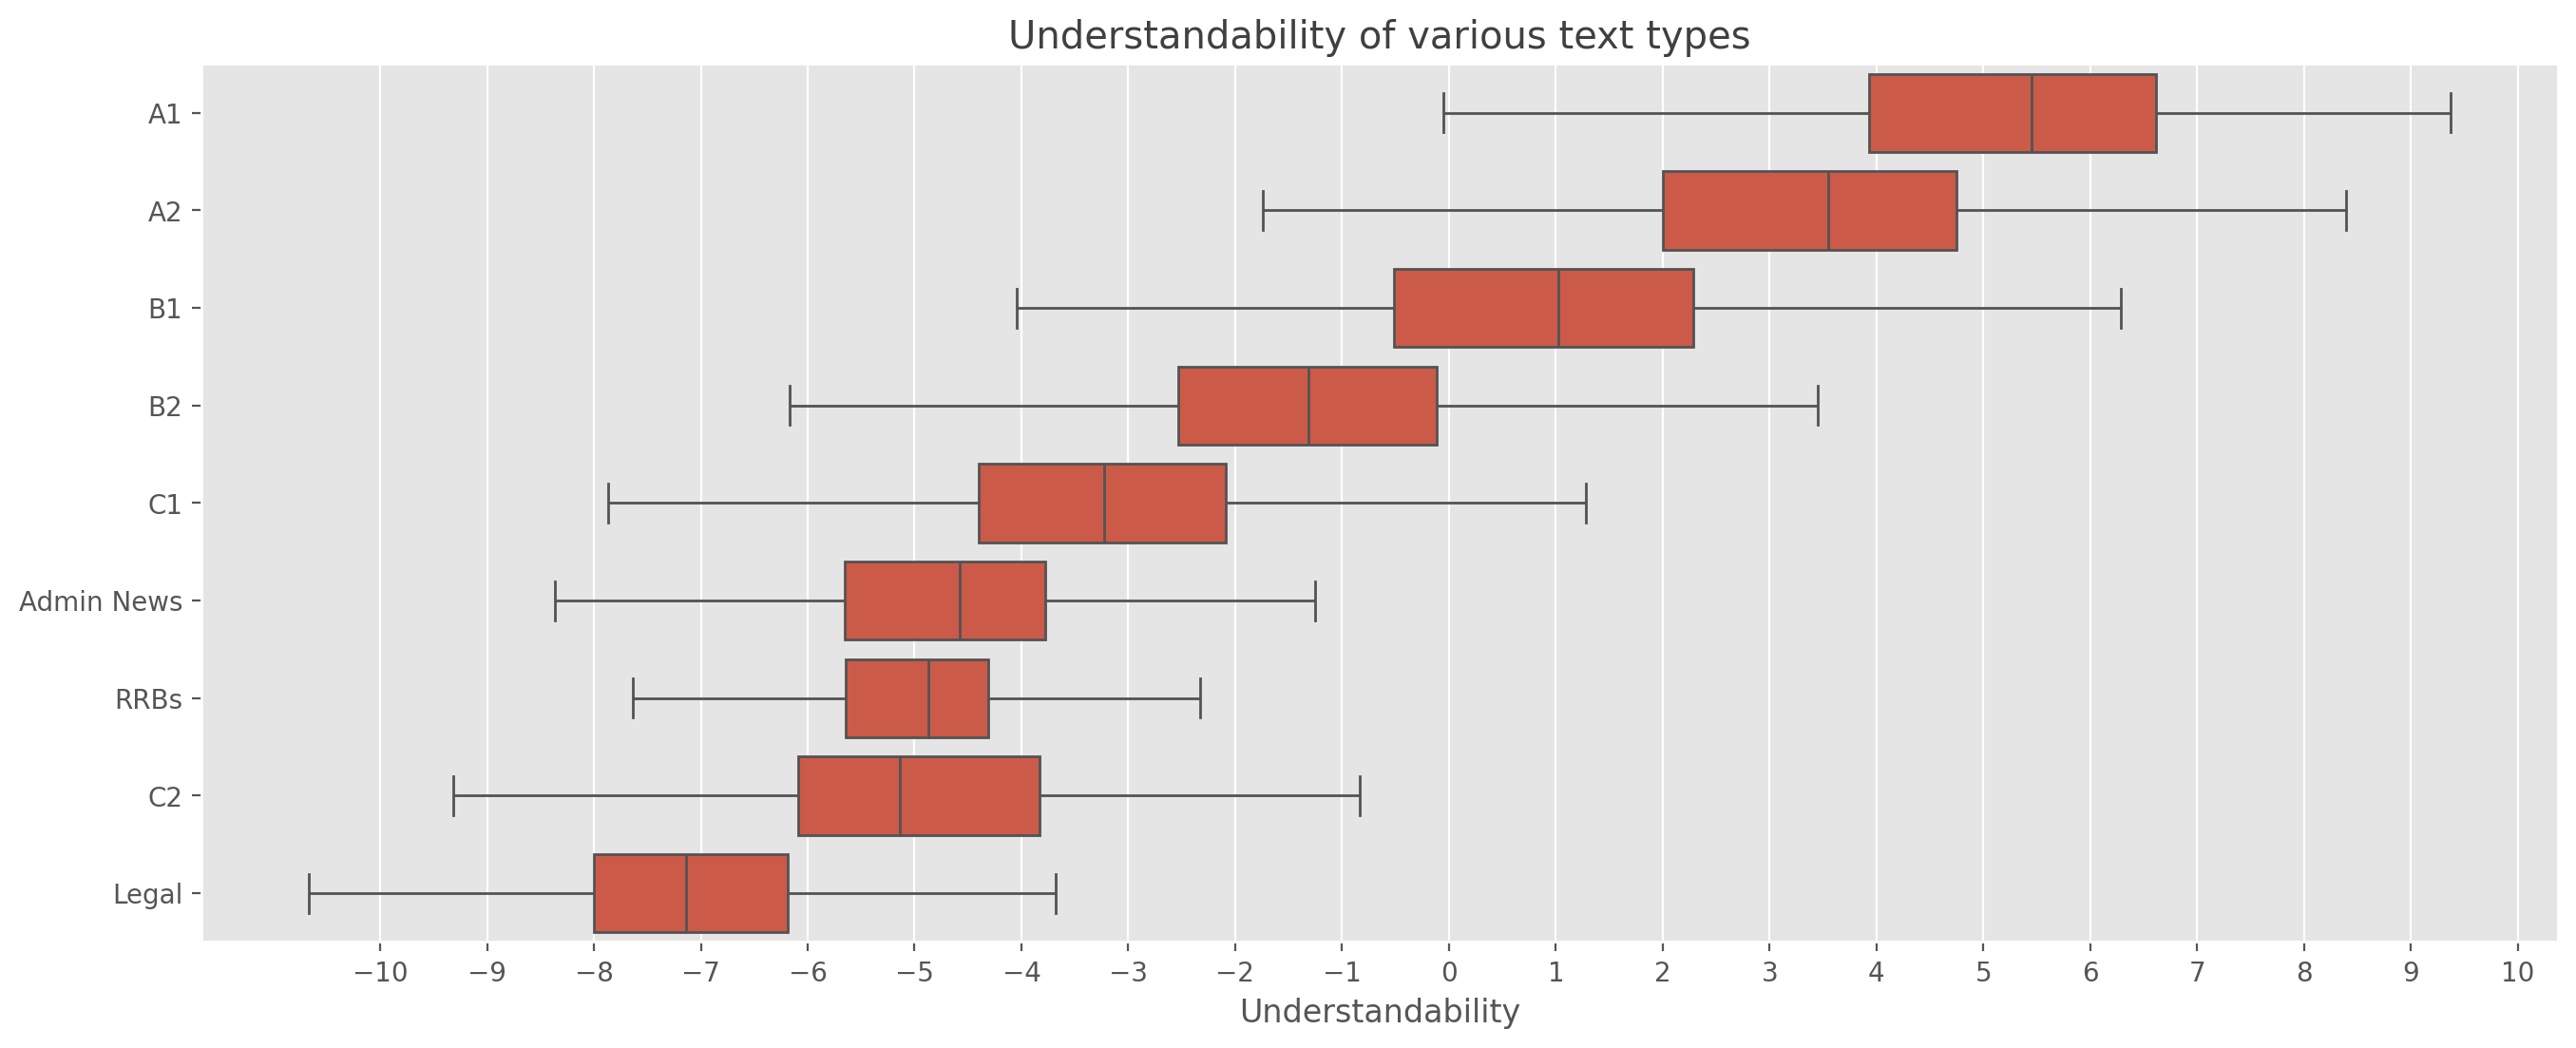

In [44]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(
    data=df,
    x="zix",
    y="text_type",
    order=order,
    orient="h",
    color=DEFAULT_COLORS[0],
    ax=ax,
    showfliers=False,
)
ax.set_title("Understandability of various text types")
ax.set_xlabel("Understandability")
ax.set_ylabel("")
ax.set_xticks(np.arange(-10, 11, 1))
plt.show()

Our features importances show a balance between syntactic, semantic and interaction features.

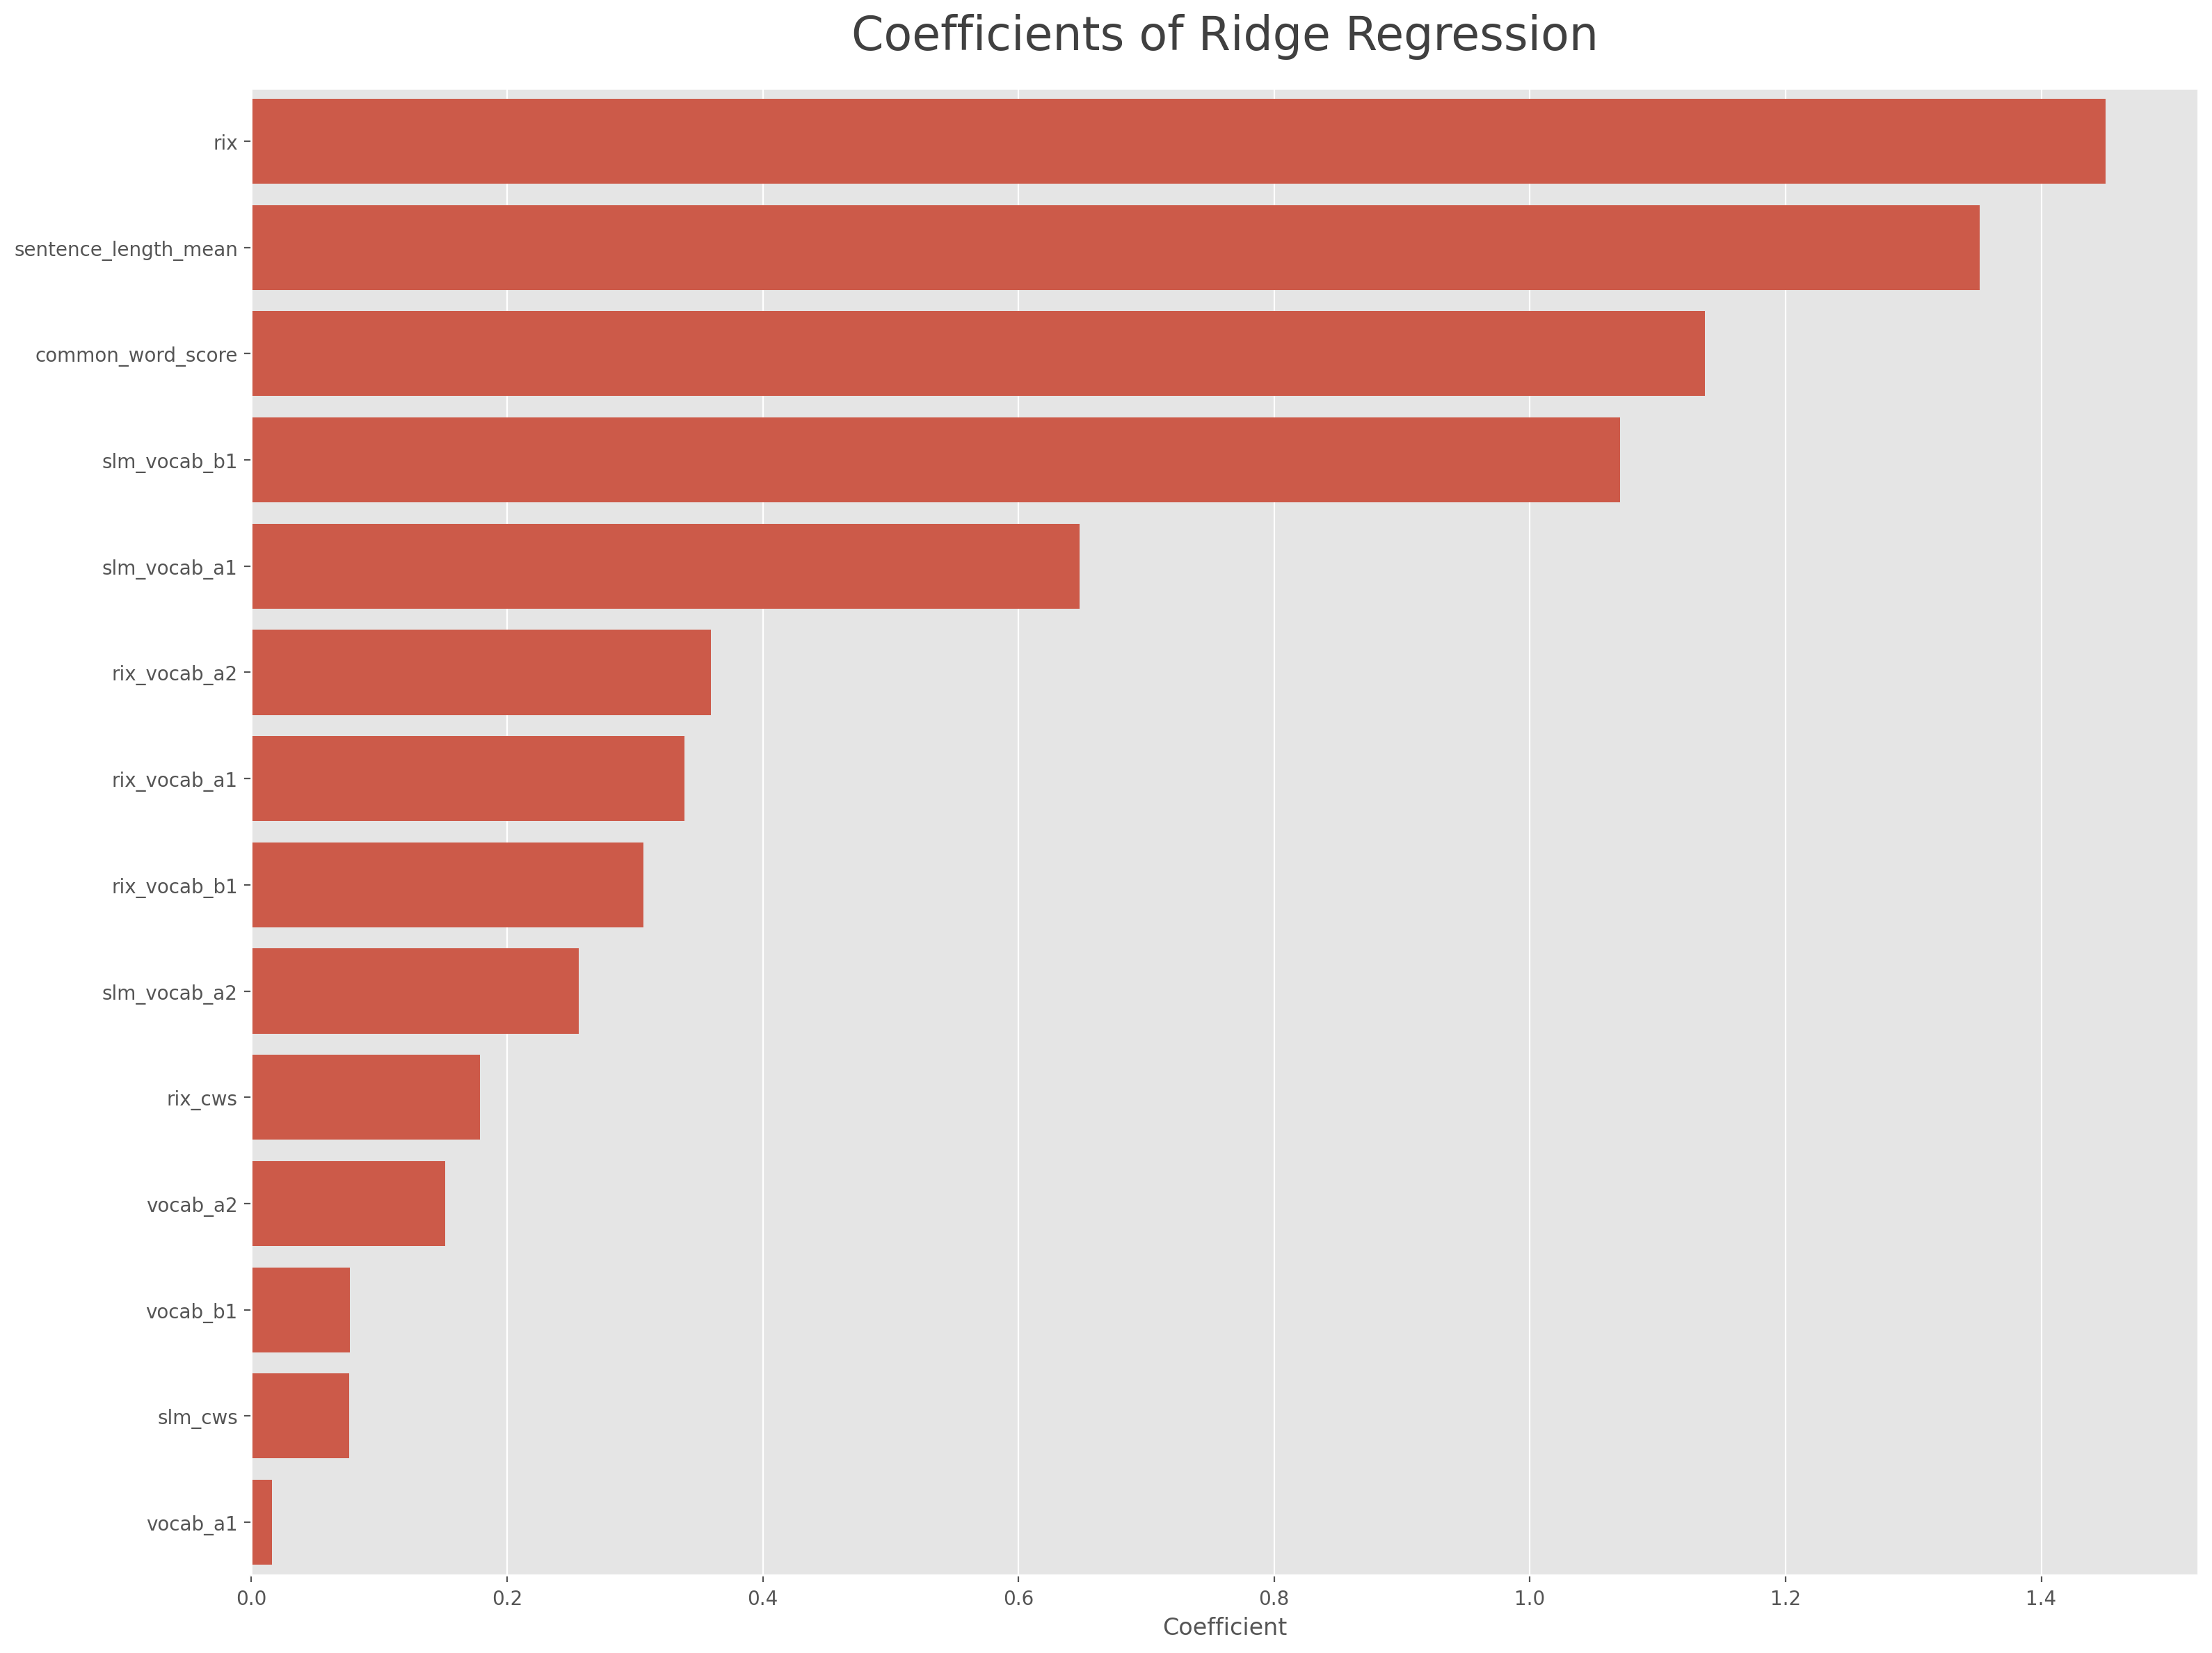

In [45]:
coefficents = sorted(
    list(zip(df_inlier[final_cols_extended].columns, clf.coef_)),
    key=lambda x: np.abs(x[1]),
    reverse=True,
)
coef = pd.DataFrame(coefficents, columns=["feature", "coefficient"])
coef["coef_abs"] = coef.coefficient.abs()
fig, ax = plt.subplots(figsize=(16, 12))
sns.barplot(data=coef, x="coef_abs", y="feature", orient="h", ax=ax)
ax.set_title("Coefficients of Ridge Regression", size=24, pad=20)
ax.set_xlabel("Coefficient")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

In [46]:
coef_sum = coef.coef_abs.sum()
coef_indexed = [np.round(x / coef_sum, 2) for x in coef.coef_abs]
print("Normalized coefficients:")
display(list(zip(coef.feature, coef_indexed)))

Normalized coefficients:


[('rix', 0.2),
 ('sentence_length_mean', 0.18),
 ('common_word_score', 0.15),
 ('slm_vocab_b1', 0.14),
 ('slm_vocab_a1', 0.09),
 ('rix_vocab_a2', 0.05),
 ('rix_vocab_a1', 0.05),
 ('rix_vocab_b1', 0.04),
 ('slm_vocab_a2', 0.03),
 ('rix_cws', 0.02),
 ('vocab_a2', 0.02),
 ('vocab_b1', 0.01),
 ('slm_cws', 0.01),
 ('vocab_a1', 0.0)]

We now try to set sensible limits for CEFR levels and create a more informative plot. CEFR levels are roughly 2 ZIX values apart and range from -4 (C2) to 4 (A1).

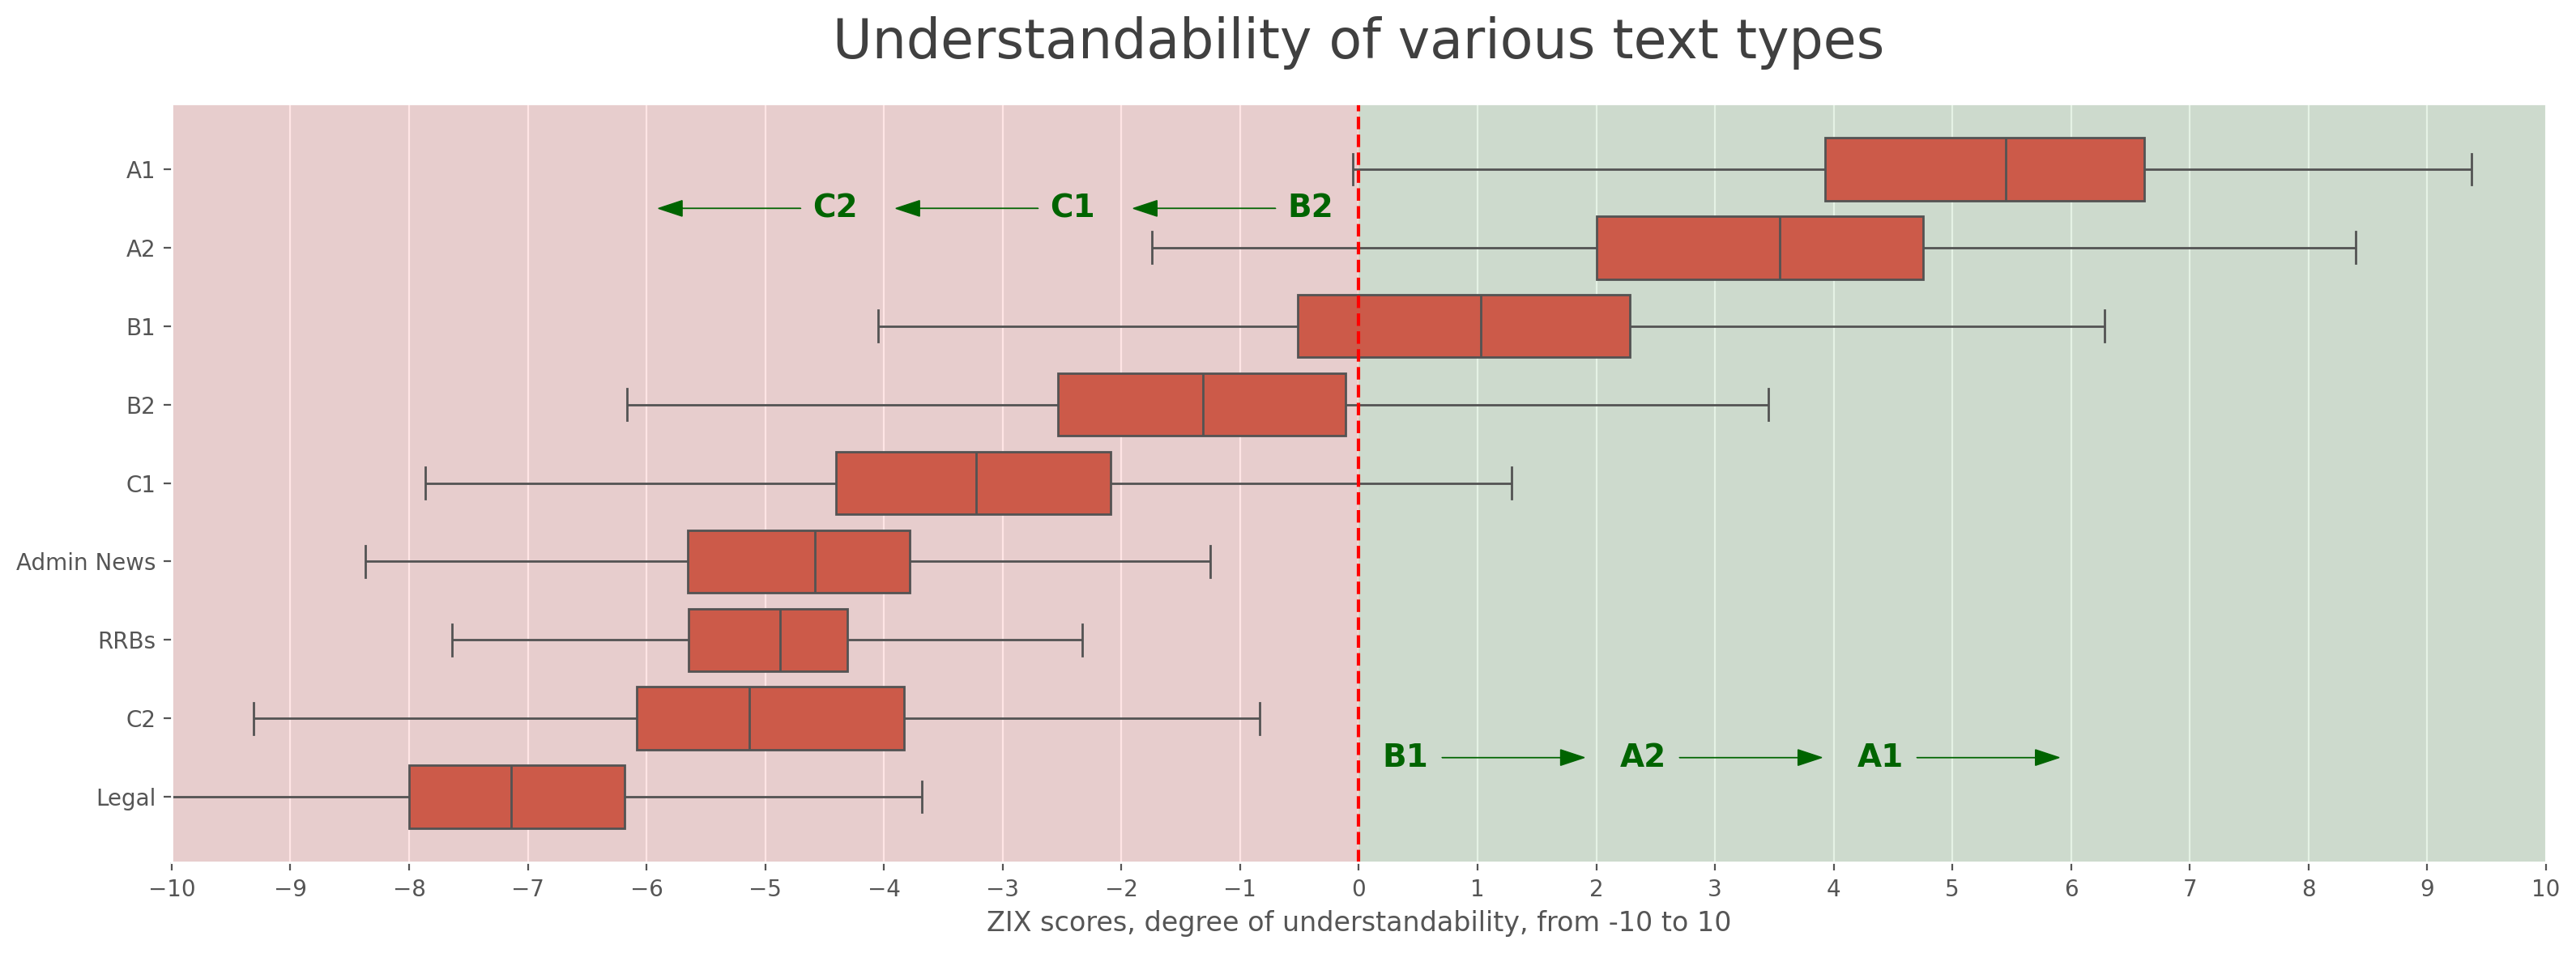

In [25]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.boxplot(
    data=df,
    x="zix",
    y="text_type",
    order=order,
    orient="h",
    color=DEFAULT_COLORS[0],
    ax=ax,
    showfliers=False,
)

ax.axvspan(0, 20, alpha=0.1, color="green")
ax.axvspan(-10, 0, alpha=0.1, color="red")
ax.axvline(0, color="red", linestyle="--")

params = {
    "fontsize": 14,
    "weight": "bold",
    "color": "darkgreen",
    "ha": "left",
    "va": "center",
}

# Rough estimates of CEFR levels.
# The ranges are adjusted for optical reasons.
# For the actual CEFR limits have a look at the package.
ax.text(4.2, 7.5, "A1", **params)
ax.text(2.2, 7.5, "A2", **params)
ax.text(0.2, 7.5, "B1", **params)
ax.text(-0.6, 0.5, "B2", **params)
ax.text(-2.6, 0.5, "C1", **params)
ax.text(-4.6, 0.5, "C2", **params)

for x_pos in (0.7, 2.7, 4.7):
    ax.arrow(
        x=x_pos,
        y=7.5,
        dx=1,
        dy=0,
        head_width=0.2,
        head_length=0.2,
        fc="darkgreen",
        ec="darkgreen",
    )

for x_pos in (-0.7, -2.7, -4.7):
    ax.arrow(
        x=x_pos,
        y=0.5,
        dx=-1,
        dy=0,
        head_width=0.2,
        head_length=0.2,
        fc="darkgreen",
        ec="darkgreen",
    )

ax.set_title("Understandability of various text types", size=24, pad=20)
ax.set_ylabel("")
ax.set_xlabel("ZIX scores, degree of understandability, from -10 to 10")
ax.set_xlim(-10, 10)
ax.set_xticks(range(-10, 11))
plt.tight_layout()
plt.savefig(f"_imgs/zix_scores.jpg", dpi=300)
plt.show()

We see that ZIX scores for the various text types are distributed over a wide range. E.g. values for text type `C2` range from less than -9 up to more than -1. We can assume that we get a sensible indication from the scores. However, we'll likely encounter edge cases and outliers time and again. 

# Validate results

Let's check some samples to validate results.

In [47]:
for text in df.sort_values("zix", ascending=False).head(3).text.tolist():
    print(text)

Ich gehe zur Schule. Ich lerne viel.
Der Computer läuft langsam.
Der Nationalrat ist wichtig. Er ist in der Schweiz. Er ist ein Teil der Regierung. Viele Leute arbeiten dort. Sie machen Gesetze. Sie helfen den Menschen. Sie treffen sich oft. Sie sprechen über Probleme. Sie suchen Lösungen. Sie arbeiten zusammen.


In [48]:
for text in df.sort_values("zix", ascending=True).head(3).text.tolist():
    print(text[:500])
    print()

Im Entscheid VB.2000.00042 vom 13. April 2000 hat das Verwaltungsgericht - in Bestätigung des Rekursentscheides BRKE II Nr. 239/1999 - demgegenüber entschieden, dass die damals fragliche kommunale Vorschrift, nach welcher Abgrabungen sowohl bei Haupt- wie auch Besonderen Gebäuden zulässig waren, «sofern - 2 - sie eine natürlich erscheinende Terraingestaltung zulassen», auch auf Untergeschosse anwendbar sei, welche ein Vollgeschoss ersetzen. Zur Begründung führten das Verwaltungsgericht und die R

Du kannst dich ausführlich und argumentativ über komplexe Themen äußern, die oft einen kritischen Diskurs erfordern. Du verstehst abstrakte Konzepte und diskutierst sie in verschiedenen Bereichen des täglichen Lebens sowie im akademischen Kontext. La mondialisation pose de nombreux défis et opportunités pour l'économie française, qui doit s'adapter tout en préservant son identité culturelle unique. Les avancées dans le domaine de la biotechnologie ouvrent des perspectives nouvelles pour les so

In [49]:
print("-" * 80)
print("Easiest texts\n")
for text_type in order:
    print(text_type)
    print(
        df[df.text_type == text_type]
        .sort_values("understandability", ascending=False)
        .head(1)
        .text.values[0][:500]
    )
    print()

--------------------------------------------------------------------------------
Easiest texts

A1
Ich gehe zur Schule. Ich lerne viel.

A2
In der Schule sind viele Kinder. Wir spielen und lernen.

B1
Die Politikerin hält eine Rede im Rathaus. Sie spricht über wichtige Themen. Viele Menschen hören ihr zu. Nach der Rede gibt es eine Diskussion. Die Politikerin nimmt sich Zeit für Fragen. Sie bedankt sich am Ende bei allen.

B2
Ich arbeite oft am Computer für meine Studien. Heute habe ich eine Präsentation vorbereitet. Ich habe viele Informationen gesammelt und sie in einem Programm organisiert. Während ich arbeite, höre ich Musik. Manchmal mache ich Pausen, um frische Luft zu schnappen. Es ist wichtig, konzentriert zu bleiben. Am Ende des Tages habe ich viel erreicht.

C1
Politikerin: Der lokale Markt ist ein guter Ort, um frisches Obst zu finden. Ich gehe gerne dort hin.

Admin News
Ein Mann ist am Freitagabend (1.4.2016) an seinem Wohnort in Forch durch drei unbekannte Männer gezwunge

In [29]:
print("-" * 80)
print("Hardest texts\n")
for text_type in order:
    print(text_type)
    print(
        df[df.text_type == text_type]
        .sort_values("understandability", ascending=True)
        .head(1)
        .text.values[0][:500]
    )
    print()

--------------------------------------------------------------------------------
Hardest texts

A1
Du lernst die Grundlagen des Französischen sprechen und schreiben. Du kannst einfache Sätze bilden und grundlegende Konversationen führen. Heute ist es sonnig in Paris. Ich heiße Anna. Wie geht es dir? J'aime manger des croissants le matin. Je suis en train d'apprendre le français. Où est la bibliothèque, s'il vous plaît? Bonjour! Comment allez-vous aujourd'hui? Pouvez-vous me dire où se trouve la gare? Le chien dort sur le canapé. La pluie tombe sans arrêt en automne à Lyon.

A2
Du kannst einfache Sätze verstehen und formulieren, die sich auf dein persönliches Leben beziehen. Du beginnst, über Alltagssituationen zu sprechen. Je travaille dans un restaurant français. Pourriez-vous me recommander un bon livre? Ma mère prépare toujours une quiche pour le déjeuner. Quel temps fait-il aujourd'hui à Marseille? J'ai acheté des fleurs pour ma grand-mère. Je voudrais réserver une chambre d'hôtel 

# Discussion

### Procedure
- Our objective was to **develop an understandability index for German texts** that provides a continuous score indicating how understandable a given text is, beyond just readability.
- In the absence of open datasets with ground truth, we created our own dataset.
- We generated text samples using Large Language Models (LLMs), incorporating the Common European Framework of Reference (CEFR) scale in the prompts, from A1 (beginner) to C2 (proficient).
- We extracted various linguistic features from the text data and selected a subset of six features representing both syntactic and semantic properties.
- By adding interaction terms, we expanded the feature set to a total of 14 features.
- To address outliers, we modeled the feature distribution using a Gaussian Mixture Model.
- We employed a Ridge Regressor to model the data, using the CEFR levels, converted to integers (1 to 6), as a proxy for the continuous difficulty of the texts.
- The Ridge model predictions were adjusted to range from -10 to 10, with 0 approximately marking the boundary between B1 and B2 levels.

### Results
- The results were promising. Testing the index with various corpora showed that it provided helpful indications of text difficulty.

### Limitations
- **The most significant limitation is the lack of ground truth data** for both developing and validating our index. We relied on synthetic data generated by LLMs, without certainty that these texts accurately reflect CEFR levels.
- Several educated guesses were made during the project, particularly in estimating the difficulties of different text types in our training data.
- As a result, the metric should be used as an indicative and pragmatic measure rather than a definitive one.
